 <hr style="border-width:4px; border-style:solid; border-color:green"/>

# Empirical Orthogonal Functions Analysis

<hr style="border-width:4px; border-style:solid; border-color:green"/>

In [1]:
from packages import *
import EOFsfunction 
import Soil_moisture_weights
import data_spliting 

## Dataset

The SPMIP data was generated with the aim of asessing the influence of parameters on the variability of Land Surface models. The CLM5 model was run using the same soil properties throughout the soil columns from 1980 - 2010. The documentaion how the data was generated can be found on [SPMIP documentation](https://www.gewexevents.org/wp-content/uploads/GLASS2017_SP-MIP_Protocol.pdfhttps://www.gewexevents.org/wp-content/uploads/GLASS2017_SP-MIP_Protocol.pdf)  

- Experiment 1: Soil-hydraulic parameters provided by SP-MIP.
   It was considered as a baseline for model spread coming everthing else than soil parameters. 

- Experiment 2: Soil-hyraulic parameters derived from common soil textural properties.

  Model variability related to the steps of transfering soil textural information to soil hydraulic properties. 

- Experiment 3: Reference run with all models in their status quo (soil parameter map). Model variability related to the use of different soil maps. 

- Experiment 4: Spatially uniform soil parameters (Loamy Sand, Loam, Clay, Silt). 

   Experiment 4 was run using different soil deigns corresponding to loamy sand (Experiment 4a), loam (experiment 4b), clay (experiment    4c), and silt (experiment 4d).

### Loading the Soil Intercomparison Model Project (SPMIP) Data 

In [2]:
path = "/scratch/ksilwimba/Data/US_data/"

data_EX1  = xr.open_dataset(path + "/CLM5_experiment_1_US_1980-2010.nc")
data_EX2  = xr.open_dataset(path + "/CLM5_experiment_2_US_1980-2010.nc")
data_EX3  = xr.open_dataset(path + "/CLM5_experiment_3_US_1980-2010.nc")
data_EX4a = xr.open_dataset(path + "/CLM5_experiment_4a_US_1980-2010.nc")
data_EX4b = xr.open_dataset(path + "/CLM5_experiment_4b_US_1980-2010.nc")
data_EX4c = xr.open_dataset(path + "/CLM5_experiment_4c_US_1980-2010.nc")
data_EX4d = xr.open_dataset(path + "/CLM5_experiment_4d_US_1980-2010.nc")

In [3]:
data_EX1

<xarray.Dataset>
Dimensions:    (time: 11315, bnds: 2, lon: 140, lat: 60, levgrnd: 25, levsoi: 20)
Coordinates:
  * time       (time) object 1980-01-02 00:00:00 ... 2011-01-01 00:00:00
  * lon        (lon) float32 230.2 230.8 231.2 231.8 ... 298.2 298.8 299.2 299.8
  * lat        (lat) float32 20.25 20.75 21.25 21.75 ... 48.25 48.75 49.25 49.75
  * levgrnd    (levgrnd) float32 0.01 0.04 0.09 0.16 ... 13.33 19.48 28.87 42.0
Dimensions without coordinates: bnds, levsoi
Data variables: (12/41)
    time_bnds  (time, bnds) object ...
    mcdate     (time) float32 ...
    mcsec      (time) float32 ...
    mdcur      (time) float32 ...
    mscur      (time) float32 ...
    nstep      (time) float32 ...
    ...         ...
    snd        (time, lat, lon) float32 ...
    preshead   (time, levgrnd, lat, lon) float32 ...
    hydcnd     (time, levgrnd, lat, lon) float32 ...
    thrmcnd    (time, levsoi, lat, lon) float32 ...
    heatcap    (time, levsoi, lat, lon) float32 ...
    lai        (time, lat, lon) float32 ...
Attributes: (12/15)
    CDI:                                  Climate Data Interface version 1.9....
    Conventions:                          CF-1.0
    source:                               Community Land Model CLM5.0
    history:                              Fri Oct 15 10:46:13 2021: cdo merge...
    time_period_freq:                     day_1
    PFT_physiological_constants_dataset:  clm5_params.c171117.nc
    ...                                   ...
    version:                              release-clm5.0.03
    username:                             oleson
    hostname:                             cheyenne
    comment:                              NOTE: None of the variables are wei...
    title:                                CLM History file information
    CDO:                                  Climate Data Operators version 1.9....

In [4]:
data_EX1.mrlsl

<xarray.DataArray 'mrlsl' (time: 11315, levsoi: 20, lat: 60, lon: 140)>
[1900920000 values with dtype=float32]
Coordinates:
  * time     (time) object 1980-01-02 00:00:00 ... 2011-01-01 00:00:00
  * lon      (lon) float32 230.2 230.8 231.2 231.8 ... 298.2 298.8 299.2 299.8
  * lat      (lat) float32 20.25 20.75 21.25 21.75 ... 48.25 48.75 49.25 49.75
Dimensions without coordinates: levsoi
Attributes:
    long_name:     water content per unit area of soil layer
    units:         kg/m2
    cell_methods:  time: mean

In [5]:
#=====================Soil Moistuire Data Dimension
data_EX1.mrlsl.shape
print("Soil moisture shape:",data_EX1.mrlsl.shape)
print("Soil moisture shape:",data_EX1.mrlsl.shape)
print("Time :",data_EX1.mrlsl.shape[0])
print("Soil layers :",data_EX1.mrlsl.shape[1])
print("Latitude :",data_EX1.mrlsl.shape[2])
print("Longitutde:",data_EX1.mrlsl.shape[3])

Soil moisture shape: (11315, 20, 60, 140)
Soil moisture shape: (11315, 20, 60, 140)
Time : 11315
Soil layers : 20
Latitude : 60
Longitutde: 140


<div class="alert alert-success">

### Weighted Average soil Moisture 
The average weighted soil moisture ($\overline{\theta}$) are computed from the water content per unit area of soil layer $\theta$ using vertical discretiazation table for the soil layers in the [CLM5 Docmuntation](https://www.cesm.ucar.edu/models/cesm2/land/CLM50_Tech_Note.pdf). The vertical discretization uses $N_{levgrnd} = $ 25 layers of which $N_{levsoil} = $20 are hydrologically and biogeochemistry active soil layers. For this research we considered 9 soil layers while noting each soil layer avaries in thickness. The node depth, $z_i (m)$, the thickness of each layer $\Delta z_i$ (m) they characterizes the soil layer structure. The folowing steps shows how the  weighted average is computed. 

1. Computed the unit depth of water ($d_{\theta}$) by summing the total water content in each 9 soil layer and dividing by the density of water ($1000kgm^{-3}$) gives Unit depth of water.
\begin{align}
d_{\theta_i} = \displaystyle\frac{\sum^{nlayer}_{i=1}\theta_i}{1000}
\end{align}

2. Computed weighted average soil moisture $\overline{\theta}$ for the 9 soil layer by summing the the computed unit depth of water and dividing with the sum of 9 layer soil thickness $\Delta z$ from 0 to 160 cm.
\begin{align}
\overline{\theta_{160}} = \displaystyle\sum^{nlayer}_{i=1}\frac{d_{\theta_i}}{\Delta z_i}
\end{align}


In [6]:
#============================Average weighted soil moisture for each experiment soil moisture SPMIP data
exp1_soilm_weighted_ave = Soil_moisture_weights.soil_weighted_ave(data_EX1)
exp2_soilm_weighted_ave = Soil_moisture_weights.soil_weighted_ave(data_EX2)
exp3_soilm_weighted_ave = Soil_moisture_weights.soil_weighted_ave(data_EX3)
exp4a_soilm_weighted_ave = Soil_moisture_weights.soil_weighted_ave(data_EX4a)
exp4b_soilm_weighted_ave = Soil_moisture_weights.soil_weighted_ave(data_EX4b)
exp4c_soilm_weighted_ave = Soil_moisture_weights.soil_weighted_ave(data_EX4c)
exp4d_soilm_weighted_ave = Soil_moisture_weights.soil_weighted_ave(data_EX4d)

print("Exp1 Weighted average soil moisture:",exp1_soilm_weighted_ave)
print("Exp2 Weighted average soil moisture:",exp2_soilm_weighted_ave)
print("Exp3 Weighted average soil moisture:",exp3_soilm_weighted_ave)
print("Exp4a Weighted average soil moisture:",exp4a_soilm_weighted_ave)
print("Exp4b Weighted average soil moisture:",exp4b_soilm_weighted_ave)
print("Exp4c Weighted average soil moisture:",exp4c_soilm_weighted_ave)
print("Exp4d Weighted average soil moisture:",exp4d_soilm_weighted_ave)

Exp1 Weighted average soil moisture: 0.3745540304978689
Exp2 Weighted average soil moisture: 0.3938839022318522
Exp3 Weighted average soil moisture: 0.3874005428949992
Exp4a Weighted average soil moisture: 0.2688321538766225
Exp4b Weighted average soil moisture: 0.34623083035151164
Exp4c Weighted average soil moisture: 0.4346072538693746
Exp4d Weighted average soil moisture: 0.5025383722782135


<div class="alert alert-success">

### 1. Empirical Orthogal Functions Analysis

Empirical Orthogal Functions were originally designed to decompose a spatial-temporal data $\mathbf{X}(t,\mathbf{s})$ which is the function of time space, where $t$  and $\mathbf{s}$ represents time and spatial positions respectively. $N$ represents the number of modes in the field applying the space $u_k(\mathbf{s})$ of the optimal set of basis functions and also the expansion functions of time $c_k(t)$.

\begin{align}
   \mathbf{X}(t,\mathbf{s}) = \sum_{k=1}^{N} c_k(t)u_k(\mathbf{s})
\end{align}

$\mathbf{s}$ reviews the spatial structures of the major factors that account for the tempral variations of $\mathbf{X}$. Additionally, $ c_k(t)$ is the  principle component (PCs) that explains how each EOFs amplitude changes over time. Morevore, Empirical orthogonal functions (EOFs) are frequently used to break down a signal with time and space varying components into a form that is simpler to understand in terms of spatial and temporal variation.Python library for spatial-temporal data analysis using EOF.Empirical orthogonal functions (EOFs) are frequently used to break down a signal with time- and space-varying components into a form that is simpler to understand in terms of spatial and temporal variation.Python library for spatial-temporal data analysis using EOF.


In geophysical sciences, a method known as EOFs analysis more commonly is widely used. By transforming a spatial-temporal data set into spatial patterns of variability and temporal projections of these patterns, EOF analysis aims to simplify spatial-temporal data sets in general. The EOFs are the spatial patterns, which may be seen as variance-based basis functions. The principal components (PCs), which are the temporal coefficients of the EOF patterns, are the related temporal projections. The original data set is merely re-expressed in terms of a variance basis in EOF analysis.

<div class="alert alert-block alert-info">
<b>NOTE:</b> Using EOFs and PCs, the original data set may be fully recreated. However, in reality, only a portion of the EOFs are frequently of interest. Occasionally one wants to build a data set that is shortened in terms of variance by reconstructing the original data set using just a small number of EOFs, or sometimes one wants to ascribe a physical meaning to each individual EOF.
</div>


### 2. Method of Solution in Empirical Orthogal Functions Solver

The approach in the EOF solver is based on singular value decomposition (SVD). For data sets with a large spatial dimension, this method is ideal since it avoids having to construct the covariance matrix directly. EOF analysis uses a spatial-temporal field as its input. An array with two or more dimensions in Python is used to represent this. A two-dimensional array with time as the first dimension and space as the second is created internally when one feeds an array or variable into an EOF solver. The algorithm identifies and removes the missing values in the array and computes the SVD. The calculated SVD is the truncated form, which only returns singular vectors (EOFs/PCs) corresponding to non-zero singular values. However, neglecting those with singular values of zero still leaves a complete answer since the singular value is connected to the proportion of variance represented by an EOF. The right singular vectors are the EOFs, the left singular vectors are the standardized PCs, and the squared singular values are the variances related to each EOF. The mathematical description of how the EOF vectors are computed are shown in the synthesis paper of my comprehensive exam. 

<div class="alert alert-block alert-info">
<b>NOTE:</b> The array must have columns with a zero-mean as a formal prerequisite for the EOF analysis.
</div>

The empirical orthogal finction analysis was computated using the code from [https://ajdawson.github.io](https://ajdawson.github.io/eofs/latest/index.html) the Python library for spatial-temporal data analysis using EOF. 

In [7]:
#===========================================================================
# Empirical Orthogal function Analysis 
#===========================================================================

import collections
collections.Iterable = collections.abc.Iterable

def Emp_Ortho_Funcs(SPMIP_data, n_eof):
    '''
    The function computes the empirical orthogonal functions and the corresponding time series by 
    initializing an EOF solver to do the EOF analysis. The Square-root of cosine of latitude weights
    are applied before the computation of EOFs from the data. In this presentation the EOFs has no
    unit and is dimensionaless. The project field projects the SPMIP data onto the EOFs to generate 
    a corresponding set of pseudo-PCs.
    '''
     
    "....Extracting SPMIP Data Shape ...."
    #=======================Extracting the shape of the SPMIP data 
    if len(SPMIP_data.shape) == 4:
        nt,nlat,nlon,ndepth = SPMIP_data.shape
    elif len(SPMIP_data.shape) == 3:
        nt,nlat,nlon = SPMIP_data.shape
    #=======================Detranding the SPMIP data 
    SPMIP_detrend = signal.detrend(SPMIP_data,axis=0, type='constant',bp=0)
    
    print("...Detrending the Data by removing the time-mean...")
    SPMIP_season = np.mean(SPMIP_detrend,axis=0)
    SPMIP_diff = SPMIP_detrend - SPMIP_season
        
    if len(SPMIP_data.shape) == 4:
        SPMIP_detrend = SPMIP_detrend.reshape((nt,ndepth,nlat,nlon), order='F')
    elif len(SPMIP_data.shape) == 3:
        SPMIP_detrend = SPMIP_detrend.reshape((nt,nlat,nlon), order='F') 
       
    print("....Checking Setting Weighting...")
    '''
    Create an EOF solver to do the EOF analysis. Square-root of cosine of 
    latitude weights are applied before the computation of EOFs.
    '''
    #=======================Square-root of cosine of latitude weights
    lats = SPMIP_data['lat'].data
    lons = SPMIP_data['lon'].data
    coslat = np.cos(np.deg2rad(lats[:]))
    wgts = np.sqrt(coslat)[..., np.newaxis]
    wgts=np.repeat(wgts[None,...],lons.shape[0],0).squeeze().T
    wgts = np.expand_dims(wgts,axis=0)
    
    ".....Initializing EOFs Solver...."
    if len(SPMIP_detrend.shape) == 4:           
        solver = Eof(SPMIP_detrend[:,:,:,:], weights=wgts,center=False) #initializing the EOFs object
    elif len(SPMIP_detrend.shape) == 3:
        solver = Eof(SPMIP_detrend[:,:,:], weights=wgts) #initializing the EOFs object
            
    print("....Decomposing Modes of SPMIP Data...")   
     #=======================Extracting EOFs modes from the SPMIP data and reconstructing the data 
    eofs = solver.eofs(neofs=n_eof,eofscaling=1)           # Empirical orthogonal functions (EOFs)
    pcs  = solver.pcs(npcs=n_eof, pcscaling=1).round(5)
    var_fracs = solver.varianceFraction()                  # Fractional EOF mode variances
    lambdas = solver.eigenvalues()                         # Eigenvalues (decreasing variances) associated with each EOF.
    errors = solver.northTest()                            # Typical errors for eigenvalues
    eofs_corr = solver.eofsAsCorrelation(neofs=n_eof)      # Correlation map EOFs 
    eofs_cov = solver.eofsAsCovariance(neofs=n_eof)        # Covariance map EOFs
    total_variance = solver.totalAnomalyVariance()
    pseudo_pcs = solver.projectField(SPMIP_detrend, neofs=n_eof) # Project a field onto the EOFs
    pseudo_pcs = (pseudo_pcs/np.std(pseudo_pcs,axis=0))
    reconstruction = solver.reconstructedField(n_eof)      # Reconstructed data field based on a subset of EOFs
    weights = solver.getWeights()                          # Weights used for the analysis
    
    print('...Correlating.....')
    #=======================Correlating EOFs time series with the SPMIP detraded data  
    '''
    Correlating the principal component of an EOF with the original time series at each
    data point.
    '''
    eof_corrpcs = np.zeros([n_eof,SPMIP_detrend.shape[1],SPMIP_detrend.shape[2]])
    for lat in range(SPMIP_detrend.shape[1]):
        for lon in range(SPMIP_detrend.shape[2]):
            for i in range(n_eof):
                eof_corrpcs[i,lat,lon]=np.corrcoef(pseudo_pcs[:,0],SPMIP_detrend[:,lat,lon])[0,1]
    
    return eofs, pcs, var_fracs, lambdas, eofs_corr, eof_corrpcs, reconstruction

## SPMIP Experiment  1-3  Soil Moisture 

In [8]:
#===========================Decomposing SPMIP soil moisture data experiment 1-3 
n_eof = 32 #number of EOFs considered
exp1_mrlsl = data_EX1.mrlsl.sel(levsoi=slice(0,12)).mean('levsoi').groupby('time.year').mean('time').isel()*exp1_soilm_weighted_ave
exp2_mrlsl = data_EX2.mrlsl.sel(levsoi=slice(0,12)).mean('levsoi').groupby('time.year').mean('time').isel()*exp2_soilm_weighted_ave
exp3_mrlsl = data_EX3.mrlsl.sel(levsoi=slice(0,12)).mean('levsoi').groupby('time.year').mean('time').isel()*exp3_soilm_weighted_ave

eofs1, pcs1, var_fracs1, eof_corrpcs, eofs_corr1, eof_corrpcs1,reconstruction1 = Emp_Ortho_Funcs(exp1_mrlsl, n_eof)
eofs2, pcs2, var_fracs2, lambdas2, eofs_corr2, eof_corrpcs2,reconstruction2 = Emp_Ortho_Funcs(exp2_mrlsl, n_eof)
eofs3, pcs3, var_fracs3, lambdas3, eofs_corr3, eof_corrpcs3,reconstruction3 = Emp_Ortho_Funcs(exp3_mrlsl, n_eof)

...Detrending the Data by removing the time-mean...
....Checking Setting Weighting...
....Decomposing Modes of SPMIP Data...
...Correlating.....
...Detrending the Data by removing the time-mean...
....Checking Setting Weighting...
....Decomposing Modes of SPMIP Data...
...Correlating.....
...Detrending the Data by removing the time-mean...
....Checking Setting Weighting...
....Decomposing Modes of SPMIP Data...
...Correlating.....


#### Visualizing the Percentage Explained Variance 
Explained variance represents the information explained using different EOFs mode. Explained variance is calculated as ratio of eigenvalue of a particular EOFs mode with total eigenvalues. It simply refers to how much of a data set's variability may be attributed to each unique primary mode.

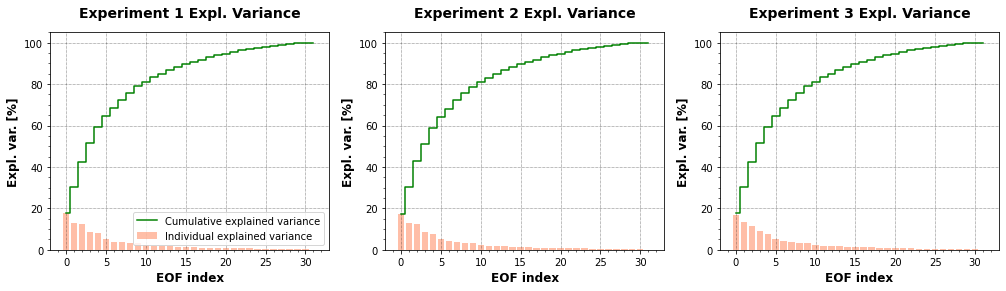

In [9]:
#===========================Explained variance against cumulative explained variance
plt.figure(figsize = (17,4))
plt.subplot(1,3,1)
Exp1_cum_sum_exp = np.cumsum(var_fracs1)
plt.bar(range(0,len(var_fracs1)), var_fracs1*100, alpha=0.5, align='center', label='Individual explained variance',color ="coral")
plt.step(range(0,len(Exp1_cum_sum_exp)), Exp1_cum_sum_exp*100, where='mid',label='Cumulative explained variance',color ="green")
plt.ylabel('Expl. var. [%]',fontweight='bold', fontsize=12)
plt.xlabel('EOF index',fontweight='bold', fontsize=12)
plt.title(f"Experiment 1 Expl. Variance", pad=15,fontweight='bold', fontsize=14)
plt.legend(loc="lower right",fontsize=10)
plt.minorticks_on()
plt.grid(linestyle=':', linewidth=0.5, color='k')

plt.subplot(1,3,2)
Exp2_cum_sum_exp = np.cumsum(var_fracs2)
plt.bar(range(0,len(var_fracs2)), var_fracs2*100, alpha=0.5, align='center', label='Individual explained variance',color ="coral")
plt.step(range(0,len(Exp2_cum_sum_exp)), Exp2_cum_sum_exp*100, where='mid',label='Cumulative explained variance',color ="green")
plt.ylabel('Expl. var. [%]',fontweight='bold', fontsize=12)
plt.xlabel('EOF index',fontweight='bold', fontsize=12)
plt.title(f"Experiment 2 Expl. Variance", pad=15,fontweight='bold', fontsize=14)
plt.minorticks_on()
plt.grid(linestyle=':', linewidth=0.5, color='k')

plt.subplot(1,3,3)
Exp3_cum_sum_exp = np.cumsum(var_fracs3)
plt.bar(range(0,len(var_fracs3)), var_fracs3*100, alpha=0.5, align='center', label='Individual explained variance',color ="coral")
plt.step(range(0,len(Exp1_cum_sum_exp)), Exp1_cum_sum_exp*100, where='mid',label='Cumulative explained variance',color ="green")
plt.ylabel('Expl. var. [%]',fontweight='bold', fontsize=12)
plt.xlabel('EOF index',fontweight='bold', fontsize=12)
plt.title(f"Experiment 3 Expl. Variance", pad=15,fontweight='bold', fontsize=14)
plt.minorticks_on()
plt.grid(linestyle=':', linewidth=0.5, color='k')
plt.show()

<div class="alert alert-success">

### Experiment 1-3 Correlation Coefficient Maps and PCs Time series 

In [10]:
#===========================Average variance explained for experiment 1-3 modes
EOFs1_aver_var_Explained = (100*var_fracs1[0]+100*var_fracs2[0]+100*var_fracs3[0])/3
EOFs2_aver_var_Explained = (100*var_fracs1[1]+100*var_fracs2[1]+100*var_fracs3[1])/3
EOFs3_aver_var_Explained = (100*var_fracs1[2]+100*var_fracs2[2]+100*var_fracs3[2])/3

### Visualize Leading EOFs

#### Correlation Coefficient Maps, EOFs and PCs 

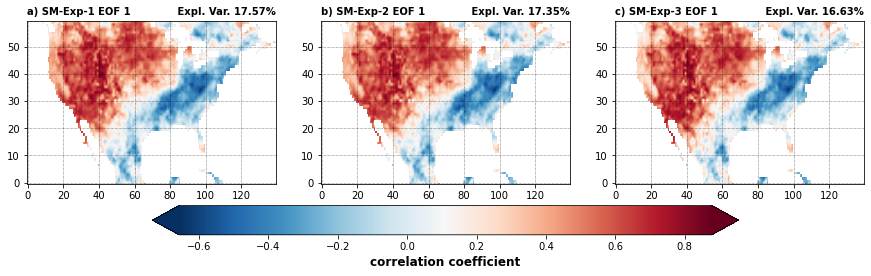

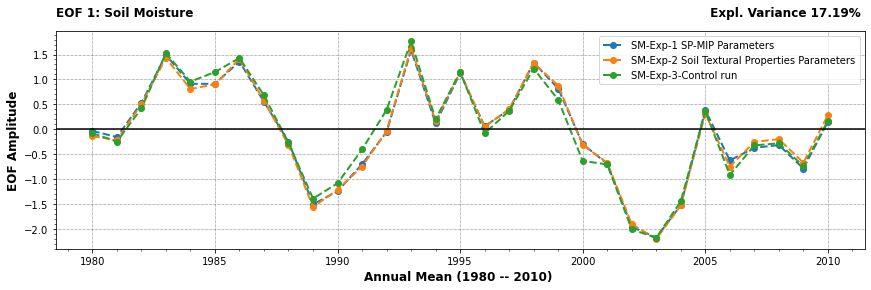

In [11]:
#============================================EOF Spatial Correlation Maps 
fig, axs = plt.subplots(nrows=1,ncols=3, \
                        sharex=True, figsize=[15,4], gridspec_kw={'wspace':.18, 'hspace':.22})
kwargs = {'format': '%.0f'} 
 
axs[0].set_title('a) SM-Exp-1 EOF 1',fontweight='bold', fontsize=10, loc='left') #
original1=axs[0].imshow(eofs_corr1[0,:,:].squeeze() , \
                        cmap='RdBu_r', interpolation='bilinear', aspect='auto', origin='lower')
axs[0].set_title(f" Expl. Var. {(var_fracs1[0]*100).round(2)}%", loc='right',fontweight='bold',size=10)
axs[0].grid(linestyle=':', linewidth=0.5, color='k')

axs[1].set_title('b) SM-Exp-2 EOF 1', fontweight='bold',fontsize=10, loc='left')
original2=axs[1].imshow(eofs_corr2[0,:,:].squeeze(), \
                        cmap='RdBu_r', interpolation='bilinear', aspect='auto', origin='lower')
axs[1].set_title(f" Expl. Var. {(var_fracs2[0]*100).round(2)}%", loc='right',fontweight='bold',size=10)
axs[1].grid(linestyle=':', linewidth=0.5, color='k')

axs[2].set_title('c) SM-Exp-3 EOF 1',fontweight='bold', fontsize=10, loc='left')
original3=axs[2].imshow(eofs_corr3[0,:,:].squeeze(),\
                        cmap='RdBu_r', interpolation='bilinear', aspect='auto', origin='lower')
axs[2].set_title(f" Expl. Var. {(var_fracs3[0]*100).round(2)}%", loc='right',fontweight='bold',size=10)
axs[2].grid(linestyle=':', linewidth=0.5, color='k')

cb =plt.colorbar(original1, cmap='RdBu_r', \
                 ax=axs.ravel().tolist(), orientation='horizontal', shrink=0.7,extend='both', pad=0.099)
cb.set_label('correlation coefficient',fontweight='bold', fontsize=12)#.set_label(label='new label',size=15,weight='bold')

#============================================EOF Time Series 

plt.figure(figsize = (14.5,4))
years = np.arange(1980,2011,1)
plt.plot(years, np.delete(pcs1[:,0],-1),\
         label="SM-Exp-1 SP-MIP Parameters",linewidth=2,linestyle='dashed',   marker="o")
plt.plot(years, np.delete(pcs2[:,0],-1), \
         linewidth=2,label="SM-Exp-2 Soil Textural Properties Parameters",linestyle='dashed',   marker="o")
plt.plot(years, np.delete(pcs3[:,0],-1), \
         linewidth=2,label="SM-Exp-3-Control run",linestyle='dashed',  marker="o")
plt.xlabel("Annual Mean (1980 -- 2010) ",fontweight='bold',fontsize=12)
plt.ylabel("EOF Amplitude",fontweight='bold',  fontsize=12)
plt.title(f" Expl. Variance {EOFs1_aver_var_Explained.round(2)}% ",fontweight='bold', loc='right',size=12)
plt.title(f"EOF 1: Soil Moisture ",loc="left", pad=15,fontweight='bold', fontsize=12)
plt.legend(loc="upper right", fontsize=8)
#plt.axhline(0, color='k')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.axhline(0, color='k')
plt.minorticks_on()
plt.legend()
plt.grid(linestyle=':', linewidth=0.5, color='k')
plt.show()

A variation was observed for the first EOF experdiment 2 was different from other experiments.

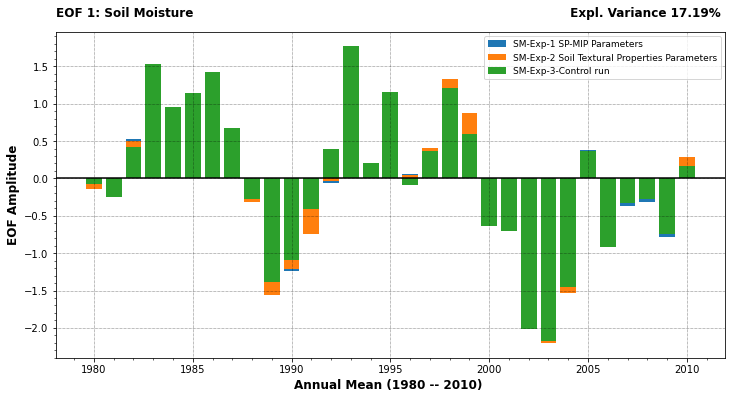

In [12]:
#============================================EOF Bar Stack 
plt.figure(figsize = (12,6))
years = np.arange(1980,2011,1)
plt.bar(years, np.delete(pcs1[:,0],-1),label="SM-Exp-1 SP-MIP Parameters")
plt.bar(years, np.delete(pcs2[:,0],-1),label="SM-Exp-2 Soil Textural Properties Parameters")
plt.bar(years, np.delete(pcs3[:,0],-1), label="SM-Exp-3-Control run")
plt.xlabel("Annual Mean (1980 -- 2010) ",fontweight='bold',fontsize=12)
plt.ylabel("EOF Amplitude",fontweight='bold',  fontsize=12)
plt.title(f" Expl. Variance {EOFs1_aver_var_Explained.round(2)}% ",fontweight='bold', loc='right',size=12)
plt.title(f"EOF 1: Soil Moisture ",loc="left", pad=15,fontweight='bold', fontsize=12)
plt.legend(loc="upper right", fontsize=9)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.axhline(0, color='k')
plt.minorticks_on()
plt.grid(linestyle=':', linewidth=0.5, color='k')
plt.show()

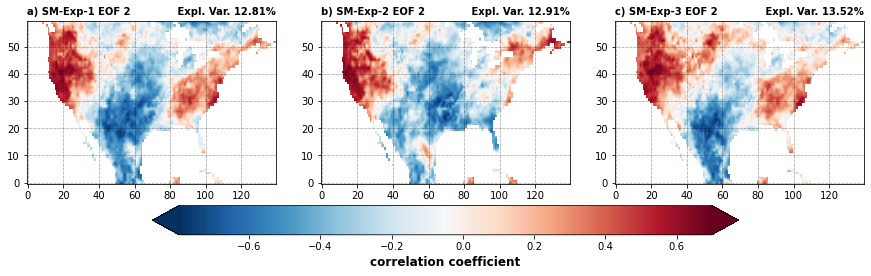

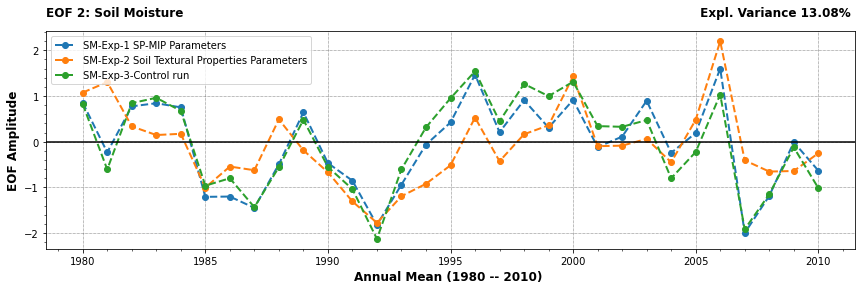

In [13]:
#============================================EOF Spatial Correlation Maps 
fig, axs = plt.subplots(nrows=1,ncols=3, sharex=True, figsize=[15,4], gridspec_kw={'wspace':.18, 'hspace':.22})
kwargs = {'format': '%.0f'} 
 
axs[0].set_title('a) SM-Exp-1 EOF 2',fontweight='bold', fontsize=10, loc='left')
original1=axs[0].imshow(eofs_corr1[1,:,:].squeeze() , \
                        cmap='RdBu_r', interpolation='bilinear', aspect='auto', origin='lower')
axs[0].set_title(f" Expl. Var. {(var_fracs1[1]*100).round(2)}%", loc='right',fontweight='bold',size=10)
axs[0].grid(linestyle=':', linewidth=0.5, color='k')

axs[1].set_title('b) SM-Exp-2 EOF 2', fontweight='bold',fontsize=10, loc='left')
original2=axs[1].imshow(eofs_corr2[1,:,:].squeeze(), \
                        cmap='RdBu_r', interpolation='bilinear', aspect='auto', origin='lower')
axs[1].set_title(f" Expl. Var. {(var_fracs2[1]*100).round(2)}%", loc='right',fontweight='bold',size=10)
axs[1].grid(linestyle=':', linewidth=0.5, color='k')

axs[2].set_title('c) SM-Exp-3 EOF 2',fontweight='bold', fontsize=10, loc='left')
original3=axs[2].imshow(eofs_corr3[1,:,:].squeeze(),\
                        cmap='RdBu_r', interpolation='bilinear', aspect='auto', origin='lower')
axs[2].set_title(f" Expl. Var. {(var_fracs3[1]*100).round(2)}%", loc='right',fontweight='bold',size=10)
axs[2].grid(linestyle=':', linewidth=0.5, color='k')

cb =plt.colorbar(original2, cmap='RdBu_r', \
                 ax=axs.ravel().tolist(), orientation='horizontal', shrink=0.7,extend='both', pad=0.099)
cb.set_label('correlation coefficient',fontweight='bold', fontsize=12)#.set_label(label='new label',size=15,weight='bold')

#============================================EOF Time Series 
plt.figure(figsize = (14.5,4))
years = np.arange(1980,2011,1)
plt.plot(years, np.delete(pcs1[:,1],-1), \
         label="SM-Exp-1 SP-MIP Parameters",linewidth=2,linestyle='dashed',   marker="o")
plt.plot(years, np.delete(pcs2[:,1],-1), \
         linewidth=2,label="SM-Exp-2 Soil Textural Properties Parameters",linestyle='dashed',   marker="o")
plt.plot(years, np.delete(pcs3[:,1],-1),\
         linewidth=2,label="SM-Exp-3-Control run",linestyle='dashed',  marker="o")
plt.xlabel("Annual Mean (1980 -- 2010) ",fontweight='bold',fontsize=12)
plt.ylabel("EOF Amplitude",fontweight='bold',  fontsize=12)
plt.title(f" Expl. Variance {EOFs2_aver_var_Explained.round(2)}% ",fontweight='bold', loc='right',size=12)
plt.title(f"EOF 2: Soil Moisture ",loc="left", pad=15,fontweight='bold', fontsize=12)#[kgm$^{-2}$]
plt.legend(loc="upper right", fontsize=8)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.axhline(0, color='k')
plt.minorticks_on()
plt.legend(loc='upper left')
plt.grid(linestyle=':', linewidth=0.5, color='k')
plt.show()

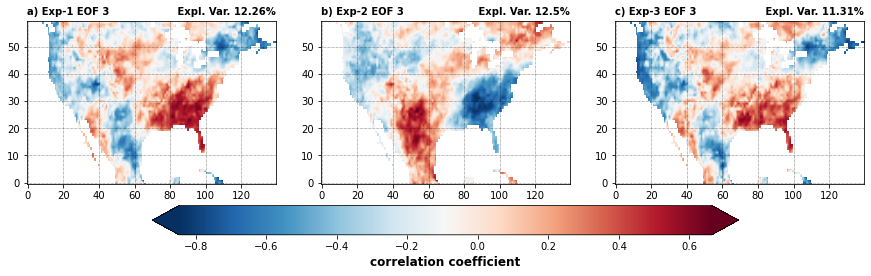

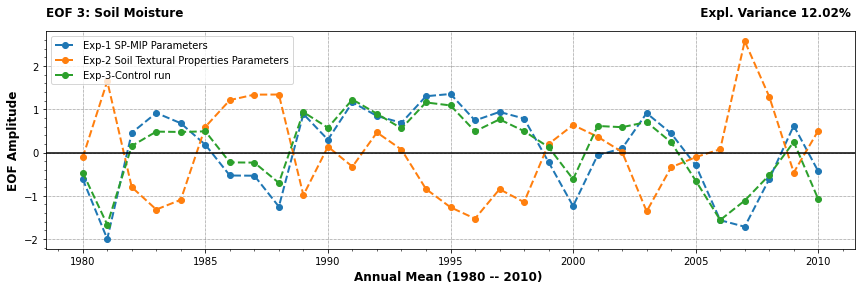

In [14]:
#============================================EOF Spatial Correlation Maps 
fig, axs = plt.subplots(nrows=1,ncols=3, sharex=True, \
                        figsize=[15,4], gridspec_kw={'wspace':.18, 'hspace':.23})
kwargs = {'format': '%.0f'} 
 
axs[0].set_title('a) Exp-1 EOF 3',fontweight='bold', fontsize=10, loc='left')
original1=axs[0].imshow(eofs_corr1[2,:,:] , \
                        cmap='RdBu_r', interpolation='bilinear', aspect='auto', origin='lower')
axs[0].set_title(f" Expl. Var. {(var_fracs1[2]*100).round(2)}%", loc='right',fontweight='bold',size=10)
axs[0].grid(linestyle=':', linewidth=0.5, color='k')

axs[1].set_title('b) Exp-2 EOF 3', fontweight='bold',fontsize=10, loc='left')
original2=axs[1].imshow(eofs_corr2[2,:,:], \
                        cmap='RdBu_r', interpolation='bilinear', aspect='auto', origin='lower')
axs[1].set_title(f" Expl. Var. {(var_fracs2[2]*100).round(2)}%", loc='right',fontweight='bold',size=10)
axs[1].grid(linestyle=':', linewidth=0.5, color='k')

axs[2].set_title('c) Exp-3 EOF 3',fontweight='bold', fontsize=10, loc='left')
original3=axs[2].imshow(eofs_corr3[2,:,:], \
                        cmap='RdBu_r', interpolation='bilinear', aspect='auto', origin='lower')
axs[2].set_title(f" Expl. Var. {(var_fracs3[2]*100).round(2)}%", loc='right',fontweight='bold',size=10)
axs[2].grid(linestyle=':', linewidth=0.5, color='k')
 

cb =plt.colorbar(original2, cmap='RdBu_r', \
                 ax=axs.ravel().tolist(), orientation='horizontal', shrink=0.7,extend='both', pad=0.099)
cb.set_label('correlation coefficient',fontweight='bold', fontsize=12)#.set_label(label='new label',size=15,weight='bold')

#============================================EOF Time Series 
plt.figure(figsize = (14.5,4))
years = np.arange(1980,2011,1)
plt.plot(years, np.delete(pcs1[:,2],-1), \
         label="Exp-1 SP-MIP Parameters",linewidth=2,linestyle='dashed',   marker="o")
plt.plot(years, np.delete(pcs2[:,2],-1), \
         linewidth=2,label="Exp-2 Soil Textural Properties Parameters", linestyle='dashed',  marker="o")
plt.plot(years, np.delete(pcs3[:,2],-1), \
         linewidth=2,label="Exp-3-Control run",linestyle='dashed',  marker="o")
plt.xlabel("Annual Mean (1980 -- 2010) ",fontweight='bold',fontsize=12)
plt.ylabel("EOF Amplitude",fontweight='bold',  fontsize=12)
plt.title(f"  Expl. Variance {EOFs3_aver_var_Explained.round(2)}% ",fontweight='bold', loc='right',size=12)
plt.title(f"EOF 3: Soil Moisture ",loc="left", pad=15,fontweight='bold', fontsize=12)
plt.legend(loc="upper right", fontsize=8)

plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.minorticks_on()
plt.axhline(0, color='k')
plt.legend(loc='upper left')
plt.grid(linestyle=':', linewidth=0.5, color='k')
plt.show()
#save('/home/ksilwimba/EOF/et_eof1', ext='png', close=True, verbose=True)

### SPMIP Experiment  4a-d  Soil Moisture 

In [15]:
#===========================Decomposing SPMIP soil moisture data experiment 4a-d 
n_eof = 20 #number of EOFs considered
exp4a_mrlsl = data_EX4a.mrlsl.sel(levsoi=slice(0,12)).mean('levsoi').groupby('time.year').mean('time').isel()*exp4a_soilm_weighted_ave
exp4b_mrlsl = data_EX4b.mrlsl.sel(levsoi=slice(0,12)).mean('levsoi').groupby('time.year').mean('time').isel()*exp4b_soilm_weighted_ave
exp4c_mrlsl = data_EX4c.mrlsl.sel(levsoi=slice(0,12)).mean('levsoi').groupby('time.year').mean('time').isel()*exp4c_soilm_weighted_ave
exp4d_mrlsl = data_EX4d.mrlsl.sel(levsoi=slice(0,12)).mean('levsoi').groupby('time.year').mean('time').isel()*exp4d_soilm_weighted_ave

eofs4a, pcs4a, var_fracs4a, lambdas4a, eofs_corr4a, eof_corrpcs4a, reconstruction4a = Emp_Ortho_Funcs(exp4a_mrlsl, n_eof)
eofs4b, pcs4b, var_fracs4b, lambdas4b, eofs_corr4b, eof_corrpcs4b, reconstruction4b = Emp_Ortho_Funcs(exp4b_mrlsl, n_eof)
eofs4c, pcs4c, var_fracs4c, lambdas4c, eofs_corr4c, eof_corrpcs4c, reconstruction4c = Emp_Ortho_Funcs(exp4c_mrlsl, n_eof)
eofs4d, pcs4d, var_fracs4d, lambdas4d, eofs_corr4d, eof_corrpcs4d, reconstruction4d = Emp_Ortho_Funcs(exp4d_mrlsl, n_eof)

...Detrending the Data by removing the time-mean...
....Checking Setting Weighting...
....Decomposing Modes of SPMIP Data...
...Correlating.....
...Detrending the Data by removing the time-mean...
....Checking Setting Weighting...
....Decomposing Modes of SPMIP Data...
...Correlating.....
...Detrending the Data by removing the time-mean...
....Checking Setting Weighting...
....Decomposing Modes of SPMIP Data...
...Correlating.....
...Detrending the Data by removing the time-mean...
....Checking Setting Weighting...
....Decomposing Modes of SPMIP Data...
...Correlating.....


#### Visualizing Percentage Explained Variance

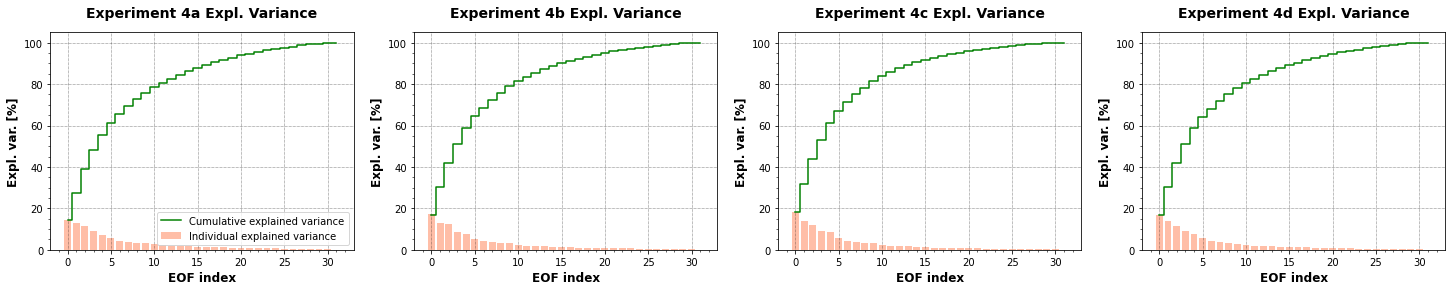

In [16]:
#===========================Explained variance against cumulative explained variance
plt.figure(figsize = (25,4))
plt.subplot(1,4,1)
Exp4a_cum_sum_exp = np.cumsum(var_fracs4a)
plt.bar(range(0,len(var_fracs4a)), var_fracs4a*100, alpha=0.5, align='center', label='Individual explained variance',color ="coral")
plt.step(range(0,len(Exp4a_cum_sum_exp)), Exp4a_cum_sum_exp*100, where='mid',label='Cumulative explained variance',color ="green")
plt.ylabel('Expl. var. [%]',fontweight='bold', fontsize=12)
plt.xlabel('EOF index',fontweight='bold', fontsize=12)
plt.title(f"Experiment 4a Expl. Variance", pad=15,fontweight='bold', fontsize=14)
plt.legend(loc="lower right",fontsize=10)
plt.minorticks_on()
plt.grid(linestyle=':', linewidth=0.5, color='k')

plt.subplot(1,4,2)
Exp4b_cum_sum_exp = np.cumsum(var_fracs4b)
plt.bar(range(0,len(var_fracs4b)), var_fracs2*100, alpha=0.5, align='center', label='Individual explained variance',color ="coral")
plt.step(range(0,len(Exp4b_cum_sum_exp)), Exp4b_cum_sum_exp*100, where='mid',label='Cumulative explained variance',color ="green")
plt.ylabel('Expl. var. [%]',fontweight='bold', fontsize=12)
plt.xlabel('EOF index',fontweight='bold', fontsize=12)
plt.title(f"Experiment 4b Expl. Variance", pad=15,fontweight='bold', fontsize=14)
plt.minorticks_on()
plt.grid(linestyle=':', linewidth=0.5, color='k')

plt.subplot(1,4,3)
Exp4c_cum_sum_exp = np.cumsum(var_fracs4c)
plt.bar(range(0,len(var_fracs4c)), var_fracs4c*100, alpha=0.5, align='center', label='Individual explained variance',color ="coral")
plt.step(range(0,len(Exp4c_cum_sum_exp)), Exp4c_cum_sum_exp*100, where='mid',label='Cumulative explained variance',color ="green")
plt.ylabel('Expl. var. [%]',fontweight='bold', fontsize=12)
plt.xlabel('EOF index',fontweight='bold', fontsize=12)
plt.title(f"Experiment 4c Expl. Variance", pad=15,fontweight='bold', fontsize=14)
plt.minorticks_on()
plt.grid(linestyle=':', linewidth=0.5, color='k')

plt.subplot(1,4,4)
Exp4d_cum_sum_exp = np.cumsum(var_fracs4d)
plt.bar(range(0,len(var_fracs4d)), var_fracs4d*100, alpha=0.5, align='center', label='Individual explained variance',color ="coral")
plt.step(range(0,len(Exp4d_cum_sum_exp)), Exp4d_cum_sum_exp*100, where='mid',label='Cumulative explained variance',color ="green")
plt.ylabel('Expl. var. [%]',fontweight='bold', fontsize=12)
plt.xlabel('EOF index',fontweight='bold', fontsize=12)
plt.title(f"Experiment 4d Expl. Variance", pad=15,fontweight='bold', fontsize=14)
plt.minorticks_on()
plt.grid(linestyle=':', linewidth=0.5, color='k')
plt.show()

In [17]:
#===========================Average variance explained for experiment 4a-d modes
EOFs14_aver_var_Explained = (100*var_fracs4a[0]+100*var_fracs4b[0]+100*var_fracs4a[0]+100*var_fracs4a[0])/4
EOFs24_aver_var_Explained = (100*var_fracs4a[1]+100*var_fracs4b[1]+100*var_fracs4a[1]+100*var_fracs4a[1])/4


###  Visualize Leading EOFs

#### Experiment 4a-d Correlation Coefficient Maps and PCs Time series 

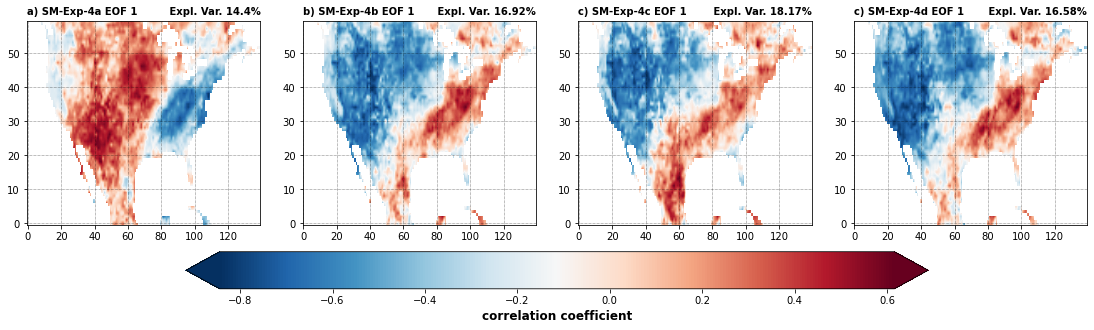

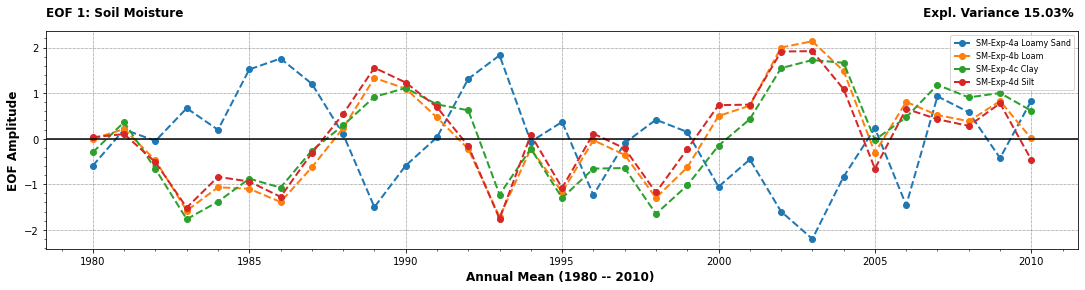

In [18]:
#============================================EOF Spatial Correlation Maps 
fig, axs = plt.subplots(nrows=1,ncols=4, sharex=True, figsize=[19,5], gridspec_kw={'wspace':.18, 'hspace':.22})
kwargs = {'format': '%.0f'} 
 
axs[0].set_title('a) SM-Exp-4a EOF 1',fontweight='bold', fontsize=10, loc='left')
original1=axs[0].imshow(eofs_corr4a[0,:,:].squeeze() , \
                        cmap='RdBu_r', interpolation='bilinear', aspect='auto', origin='lower')
axs[0].set_title(f" Expl. Var. {(var_fracs4a[0]*100).round(2)}%", loc='right',fontweight='bold',size=10)
axs[0].grid(linestyle=':', linewidth=0.5, color='k')

axs[1].set_title('b) SM-Exp-4b EOF 1', fontweight='bold',fontsize=10, loc='left')
original2=axs[1].imshow(eofs_corr4b[0,:,:].squeeze(), \
                        cmap='RdBu_r', interpolation='bilinear', aspect='auto', origin='lower')
axs[1].set_title(f" Expl. Var. {(var_fracs4b[0]*100).round(2)}%", loc='right',fontweight='bold',size=10)
axs[1].grid(linestyle=':', linewidth=0.5, color='k')

axs[2].set_title('c) SM-Exp-4c EOF 1',fontweight='bold', fontsize=10, loc='left')
original3=axs[2].imshow(eofs_corr4c[0,:,:].squeeze(), \
                        cmap='RdBu_r', interpolation='bilinear', aspect='auto', origin='lower')
axs[2].set_title(f" Expl. Var. {(var_fracs4c[0]*100).round(2)}%", loc='right',fontweight='bold',size=10)
axs[2].grid(linestyle=':', linewidth=0.5, color='k')


axs[3].set_title('c) SM-Exp-4d EOF 1',fontweight='bold', fontsize=10, loc='left')
original4=axs[3].imshow(eofs_corr4d[0,:,:].squeeze(),\
                        cmap='RdBu_r', interpolation='bilinear', aspect='auto', origin='lower')
axs[3].set_title(f" Expl. Var. {(var_fracs4d[0]*100).round(2)}%", loc='right',fontweight='bold',size=10)
axs[3].grid(linestyle=':', linewidth=0.5, color='k')
cb =plt.colorbar(original4, cmap='RdBu_r', ax=axs.ravel().tolist(), \
                 orientation='horizontal', shrink=0.7,extend='both', pad=0.099)
cb.set_label('correlation coefficient',fontweight='bold', fontsize=12)

#============================================EOF Time Series 
plt.figure(figsize = (18.5,4))
years = np.arange(1980,2011,1)
plt.plot(years, np.delete(pcs4a[:,0],-1), \
         label="SM-Exp-4a Loamy Sand",linewidth=2,linestyle='dashed',   marker="o")
plt.plot(years, np.delete(pcs4b[:,0],-1), \
         linewidth=2,label="SM-Exp-4b Loam",linestyle='dashed',   marker="o")
plt.plot(years, np.delete(pcs4c[:,0],-1), \
         linewidth=2,label="SM-Exp-4c Clay",linestyle='dashed',  marker="o")
plt.plot(years, np.delete(pcs4d[:,0],-1), \
         linewidth=2,label="SM-Exp-4d Silt",linestyle='dashed',  marker="o")
plt.xlabel("Annual Mean (1980 -- 2010) ",fontweight='bold',fontsize=12)
plt.ylabel("EOF Amplitude",fontweight='bold',  fontsize=12)
plt.title(f" Expl. Variance {EOFs14_aver_var_Explained.round(2)}% ",fontweight='bold', loc='right',size=12)
plt.title(f"EOF 1: Soil Moisture ",loc="left", pad=15,fontweight='bold', fontsize=12)
plt.legend(loc="upper right", fontsize=8)
#plt.axhline(0, color='k')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.axhline(0, color='k')
plt.minorticks_on()
# plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
#           fancybox=True, shadow=True, ncol=5)
plt.grid(linestyle=':', linewidth=0.5, color='k')
plt.show()

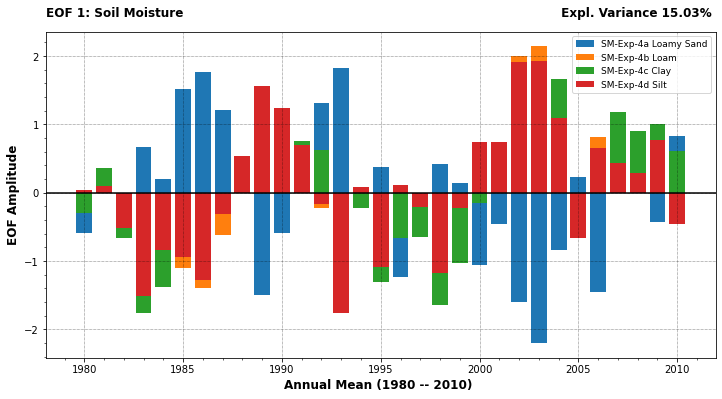

In [19]:
#============================================EOF Bar Stack 
plt.figure(figsize = (12,6))
years = np.arange(1980,2011,1)
plt.bar(years, np.delete(pcs4a[:,0],-1),label="SM-Exp-4a Loamy Sand")
plt.bar(years, np.delete(pcs4b[:,0],-1),label="SM-Exp-4b Loam")
plt.bar(years, np.delete(pcs4c[:,0],-1), label="SM-Exp-4c Clay")
plt.bar(years, np.delete(pcs4d[:,0],-1), label="SM-Exp-4d Silt")
plt.xlabel("Annual Mean (1980 -- 2010) ",fontweight='bold',fontsize=12)
plt.ylabel("EOF Amplitude",fontweight='bold',  fontsize=12)
plt.title(f" Expl. Variance {EOFs14_aver_var_Explained.round(2)}% ",fontweight='bold', loc='right',size=12)
plt.title(f"EOF 1: Soil Moisture ",loc="left", pad=15,fontweight='bold', fontsize=12)#[kgm$^{-2}$])
plt.legend(loc="upper right", fontsize=9)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.axhline(0, color='k')
plt.minorticks_on()
plt.grid(linestyle=':', linewidth=0.5, color='k')
plt.show()

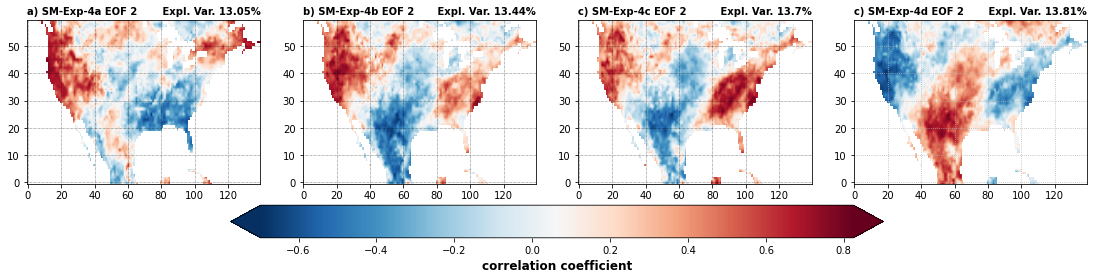

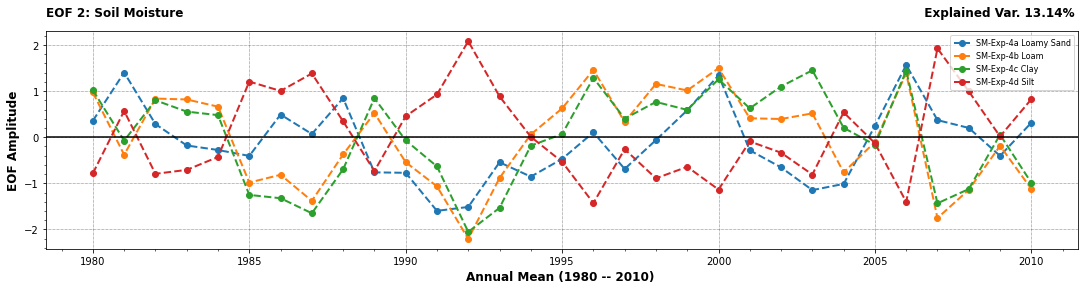

In [20]:
#============================================EOF Spatial Correlation Maps 
fig, axs = plt.subplots(nrows=1,ncols=4, sharex=True, \
                        figsize=[19,4], gridspec_kw={'wspace':.18, 'hspace':.22})
kwargs = {'format': '%.0f'} 
 
axs[0].set_title('a) SM-Exp-4a EOF 2',fontweight='bold', fontsize=10, loc='left')
original1=axs[0].imshow(eofs_corr4a[1,:,:].squeeze() , \
                        cmap='RdBu_r', interpolation='bilinear', aspect='auto', origin='lower')
axs[0].set_title(f" Expl. Var. {(var_fracs4a[1]*100).round(2)}%", loc='right',fontweight='bold',size=10)
axs[0].grid(linestyle=':', linewidth=0.5, color='k')

axs[1].set_title('b) SM-Exp-4b EOF 2', fontweight='bold',fontsize=10, loc='left')
original2=axs[1].imshow(eofs_corr4b[1,:,:].squeeze(), \
                        cmap='RdBu_r', interpolation='bilinear', aspect='auto', origin='lower')
axs[1].set_title(f" Expl. Var. {(var_fracs4b[1]*100).round(2)}%", loc='right',fontweight='bold',size=10)
axs[1].grid(linestyle=':', linewidth=0.5, color='k')

axs[2].set_title('c) SM-Exp-4c EOF 2',fontweight='bold', fontsize=10, loc='left')
original3=axs[2].imshow(eofs_corr4c[1,:,:].squeeze(), \
                        cmap='RdBu_r', interpolation='bilinear', aspect='auto', origin='lower')
axs[2].set_title(f" Expl. Var. {(var_fracs4c[1]*100).round(2)}%", loc='right',fontweight='bold',size=10)
axs[2].grid(linestyle=':', linewidth=0.5, color='k')


axs[3].set_title('c) SM-Exp-4d EOF 2',fontweight='bold', fontsize=10, loc='left')
original4=axs[3].imshow(eofs_corr4d[1,:,:].squeeze(), \
                        cmap='RdBu_r', interpolation='bilinear', aspect='auto', origin='lower')
axs[3].set_title(f" Expl. Var. {(var_fracs4d[1]*100).round(2)}%", loc='right',fontweight='bold',size=10)
axs[3].grid(linestyle=':')
cb =plt.colorbar(original4, cmap='RdBu_r', ax=axs.ravel().tolist(), \
                 orientation='horizontal', shrink=0.7,extend='both', pad=0.099)
cb.set_label('correlation coefficient',fontweight='bold', fontsize=12)#.set_label(label='new label',size=15,weight='bold')

#============================================EOF Time Series 
plt.figure(figsize = (18.5,4))
years = np.arange(1980,2011,1)
plt.plot(years, np.delete(pcs4a[:,1],-1), \
         label="SM-Exp-4a Loamy Sand",linewidth=2,linestyle='dashed',   marker="o")
plt.plot(years, np.delete(pcs4b[:,1],-1), \
         linewidth=2,label="SM-Exp-4b Loam",linestyle='dashed',   marker="o")
plt.plot(years, np.delete(pcs4c[:,1],-1), \
         linewidth=2,label="SM-Exp-4c Clay",linestyle='dashed',  marker="o")
plt.plot(years, np.delete(pcs4d[:,1],-1), \
         linewidth=2,label="SM-Exp-4d Silt",linestyle='dashed',  marker="o")
plt.xlabel("Annual Mean (1980 -- 2010) ",fontweight='bold',fontsize=12)
plt.ylabel("EOF Amplitude",fontweight='bold',  fontsize=12)
plt.title(f"  Explained Var. {EOFs24_aver_var_Explained.round(2)}% ",fontweight='bold', loc='right',size=12)
plt.title(f"EOF 2: Soil Moisture ",loc="left", pad=15,fontweight='bold', fontsize=12)
plt.legend(loc="upper right", fontsize=8)
#plt.axhline(0, color='k')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.axhline(0, color='k')
plt.minorticks_on()
# plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
#           fancybox=True, shadow=True, ncol=5)

plt.grid(linestyle=':', linewidth=0.5, color='k')
plt.show()

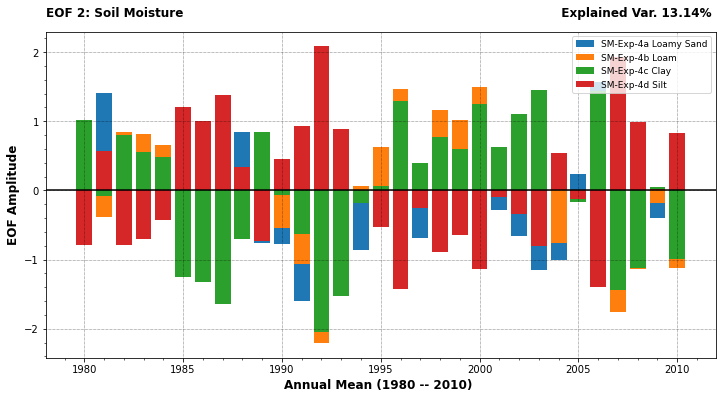

In [21]:
#============================================EOF Bar Stack 
plt.figure(figsize = (12,6))
years = np.arange(1980,2011,1)
plt.bar(years, np.delete(pcs4a[:,1],-1),label="SM-Exp-4a Loamy Sand")
plt.bar(years, np.delete(pcs4b[:,1],-1),label="SM-Exp-4b Loam")
plt.bar(years, np.delete(pcs4c[:,1],-1), label="SM-Exp-4c Clay")
plt.bar(years, np.delete(pcs4d[:,1],-1), label="SM-Exp-4d Silt")
plt.xlabel("Annual Mean (1980 -- 2010) ",fontweight='bold',fontsize=12)
plt.ylabel("EOF Amplitude",fontweight='bold',  fontsize=12)
plt.title(f"  Explained Var. {EOFs24_aver_var_Explained.round(2)}% ",fontweight='bold', loc='right',size=12)
plt.title(f"EOF 2: Soil Moisture ",loc="left", pad=15,fontweight='bold', fontsize=12)
plt.legend(loc="upper right", fontsize=9)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.axhline(0, color='k')
plt.minorticks_on()
plt.grid(linestyle=':', linewidth=0.5, color='k')
plt.show()

### Experiment 1-3 Reconstructed and Reference Dataset Spatial Maps Plot

In [22]:
soilmoisture = data_EX1.mrlsl.sel(levsoi=slice(0,1)).mean('levsoi').groupby('time.year').mean('time').isel()

#============================================Reconstructed Xarray Dataset 
Exp1mrlsl_SMreconstructed = xr.DataArray(reconstruction1,
                           coords=soilmoisture.coords, dims=soilmoisture.dims, attrs=data_EX1.attrs)
Exp2mrlsl_SMreconstructed = xr.DataArray(reconstruction2,
                           coords=soilmoisture.coords, dims=soilmoisture.dims, attrs=data_EX1.attrs)
Exp3mrlsl_SMreconstructed = xr.DataArray(reconstruction3,
                           coords=soilmoisture.coords, dims=soilmoisture.dims, attrs=data_EX1.attrs)

In [23]:
#============================================Detrending Reference Data
exp1_mrlsl_detrend = signal.detrend(exp1_mrlsl,axis=0, type='constant',bp=0)
exp2_mrlsl_detrend = signal.detrend(exp2_mrlsl,axis=0, type='constant',bp=0)
exp3_mrlsl_detrend = signal.detrend(exp3_mrlsl,axis=0, type='constant',bp=0)

#============================================Reference Xarray Dataset

exp1_mrlsl_detrendxr = xr.DataArray(exp1_mrlsl_detrend,
                           coords=soilmoisture.coords, dims=soilmoisture.dims, attrs=data_EX1.attrs)
exp2_mrlsl_detrendxr = xr.DataArray(exp2_mrlsl_detrend,
                           coords=soilmoisture.coords, dims=soilmoisture.dims, attrs=data_EX1.attrs)
exp3_mrlsl_detrendxr = xr.DataArray(exp3_mrlsl_detrend,
                           coords=soilmoisture.coords, dims=soilmoisture.dims, attrs=data_EX1.attrs)

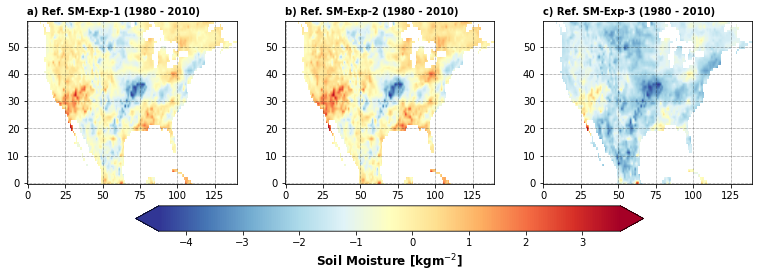

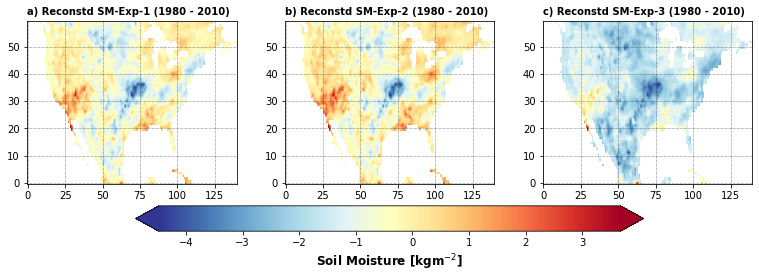

In [24]:
#============================================Reference Dataset 
fig, axs = plt.subplots(nrows=1,ncols=3, sharex=True,\
                        figsize=[13,4], gridspec_kw={'wspace':.23, 'hspace':.22})
kwargs = {'format': '%.0f'} 
 
axs[0].set_title('a) Ref. SM-Exp-1 (1980 - 2010)',fontweight='bold', fontsize=10, loc='left')
original1=axs[0].imshow(exp1_mrlsl_detrend[0,:,:].squeeze() , \
                        cmap='RdYlBu_r', interpolation='bilinear', aspect='auto', origin='lower')
#axs[0].set_title("EOF 1", loc='right',fontweight='bold',size=10)
axs[0].grid(linestyle=':', linewidth=0.5, color='k')

axs[1].set_title('b) Ref. SM-Exp-2 (1980 - 2010)', fontweight='bold',fontsize=10, loc='left')
original2=axs[1].imshow(exp2_mrlsl_detrend[0,:,:].squeeze(), \
                        cmap='RdYlBu_r', interpolation='bilinear', aspect='auto', origin='lower')
#axs[1].set_title("EOF 1", loc='right',fontweight='bold',size=10)
axs[1].grid(linestyle=':', linewidth=0.5, color='k')   

axs[2].set_title('c) Ref. SM-Exp-3 (1980 - 2010)',fontweight='bold', fontsize=10, loc='left')
original3=axs[2].imshow(exp3_mrlsl_detrend[0,:,:].squeeze(), \
                        cmap='RdYlBu_r', interpolation='bilinear', aspect='auto', origin='lower')
#axs[2].set_title("EOF 1", loc='right',fontweight='bold',size=10)
axs[2].grid(linestyle=':', linewidth=0.5, color='k')

cb =plt.colorbar(original2, cmap='RdYlBu_r', ax=axs.ravel().tolist(), \
                 orientation='horizontal', shrink=0.7,extend='both', pad=0.099)
cb.set_label('Soil Moisture [kgm$^{-2}$]',fontweight='bold', fontsize=12)#.set_label(label='new label',size=15,weight='bold')

#============================================Reconstructed Dataset

fig, axs = plt.subplots(nrows=1,ncols=3, sharex=True, \
                        figsize=[13,4], gridspec_kw={'wspace':.23, 'hspace':.22})
kwargs = {'format': '%.0f'} 
 
axs[0].set_title('a) Reconstd SM-Exp-1 (1980 - 2010)',fontweight='bold', fontsize=10, loc='left')
original1=axs[0].imshow(Exp1mrlsl_SMreconstructed [0,:,:].squeeze() , \
                        cmap='RdYlBu_r', interpolation='bilinear', aspect='auto', origin='lower')
#axs[0].set_title("EOF 1", loc='right',fontweight='bold',size=10)
axs[0].grid(linestyle=':', linewidth=0.5, color='k')

axs[1].set_title('b) Reconstd SM-Exp-2 (1980 - 2010)', \
                 fontweight='bold',fontsize=10, loc='left')
original2=axs[1].imshow(Exp2mrlsl_SMreconstructed[0,:,:].squeeze(), \
                        cmap='RdYlBu_r', interpolation='bilinear', aspect='auto', origin='lower')
#axs[1].set_title("EOF 1", loc='right',fontweight='bold',size=10)
axs[1].grid(linestyle=':', linewidth=0.5, color='k')   

axs[2].set_title('c) Reconstd SM-Exp-3 (1980 - 2010)',fontweight='bold', fontsize=10, loc='left')
original3=axs[2].imshow(Exp3mrlsl_SMreconstructed [0,:,:].squeeze(), \
                        cmap='RdYlBu_r', interpolation='bilinear', aspect='auto', origin='lower')
#axs[2].set_title("EOF 1", loc='right',fontweight='bold',size=10)
axs[2].grid(linestyle=':', linewidth=0.5, color='k')

cb =plt.colorbar(original2, cmap='RdYlBu_r', ax=axs.ravel().tolist(),\
                 orientation='horizontal', shrink=0.7,extend='both', pad=0.099)
cb.set_label('Soil Moisture [kgm$^{-2}$]',fontweight='bold', fontsize=12)#.set_label(label='new label',size=15,weight='bold')

#### Time Series of Reference and Constructed Experiment 1-3 SPMIP Dataset 

In [25]:
#=========================Reference Exp 1-3
exp1_mrlsl_detrendT = exp1_mrlsl_detrendxr.mean(dim=("lat","lon"))
exp2_mrlsl_detrendT = exp2_mrlsl_detrendxr.mean(dim=("lat","lon"))
exp3_mrlsl_detrendT = exp3_mrlsl_detrendxr.mean(dim=("lat","lon"))

#=========================Reconstructed Exp 1-3
Exp1mrlsl_SMreconstructedT = Exp1mrlsl_SMreconstructed.mean(dim=("lat","lon"))
Exp2mrlsl_SMreconstructedT = Exp2mrlsl_SMreconstructed.mean(dim=("lat","lon"))
Exp3mrlsl_SMreconstructedT = Exp3mrlsl_SMreconstructed.mean(dim=("lat","lon"))

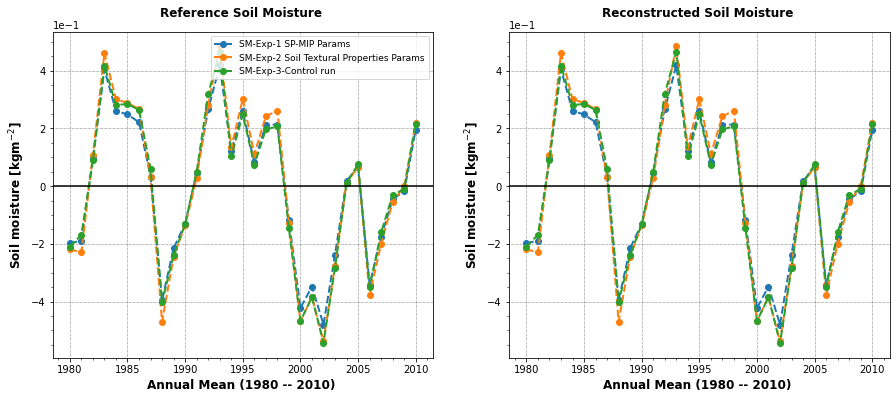

In [26]:
plt.figure(figsize = (15,6))
year = np.arange(1980,2011,1)
#============================================Reference Dataset 
plt.subplot(1,2,1)
plt.plot(year, np.delete(exp1_mrlsl_detrendT ,-1), \
         label="SM-Exp-1 SP-MIP Params",linewidth=2,linestyle='dashed',   marker="o")
plt.plot(year, np.delete(exp2_mrlsl_detrendT ,-1), \
         linewidth=2,label="SM-Exp-2 Soil Textural Properties Params",linestyle='dashed',   marker="o")
plt.plot(year, np.delete(exp3_mrlsl_detrendT ,-1), \
         linewidth=2,label="SM-Exp-3-Control run",linestyle='dashed',  marker="o")
plt.xlabel("Annual Mean (1980 -- 2010) ",fontweight='bold',fontsize=12)
plt.ylabel("Soil moisture [kgm$^{-2}$]",fontweight='bold',  fontsize=12)
plt.title(f"Reference Soil Moisture ", pad=15,fontweight='bold', fontsize=12)#
plt.legend(loc="upper right", fontsize=9)
#plt.axhline(0, color='k')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.axhline(0, color='k')
plt.minorticks_on()
# plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
#           fancybox=True, shadow=True, ncol=5)
plt.grid(linestyle=':', linewidth=0.5, color='k')

#============================================Reconstructed Dataset 
plt.subplot(1,2,2)
plt.plot(year, np.delete(Exp1mrlsl_SMreconstructedT,-1), \
         label="SM-Exp-1 SP-MIP Params",linewidth=2,linestyle='dashed',   marker="o")
plt.plot(year, np.delete(Exp2mrlsl_SMreconstructedT,-1), \
         linewidth=2,label="SM-Exp-2 Soil Textural Properties Params",linestyle='dashed',   marker="o")
plt.plot(year, np.delete(Exp3mrlsl_SMreconstructedT,-1), \
         linewidth=2,label="SM-Exp-3-Control run",linestyle='dashed',  marker="o")
plt.xlabel("Annual Mean (1980 -- 2010) ",fontweight='bold',fontsize=12)
plt.ylabel("Soil moisture [kgm$^{-2}$]",fontweight='bold',  fontsize=12)
plt.title(f"Reconstructed Soil Moisture ", pad=15,fontweight='bold', fontsize=12)#[kgm$^{-2}$]
#plt.title(f" {var3.round(2)}% of Variance", loc='right',fontweight='bold',size=12)
#plt.xticks(np.arange(12)+1, ['J','F','M','A','M','J','J','A','S','O','N','D'])
#plt.legend(loc="upper right", fontsize=8)
#plt.axhline(0, color='k')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.axhline(0, color='k')
plt.minorticks_on()
#plt.legend(loc='upper center', bbox_to_anchor=(-0.1, -0.15),
#          fancybox=True, shadow=True, ncol=5)

plt.grid(linestyle=':', linewidth=0.5, color='k')
plt.show()

### Exploring the variability by adding the daily standard deviation as a shaded area to the plot

The standard deviation allows us to see when EOF underpredicts or overpredicts the soil moisture.

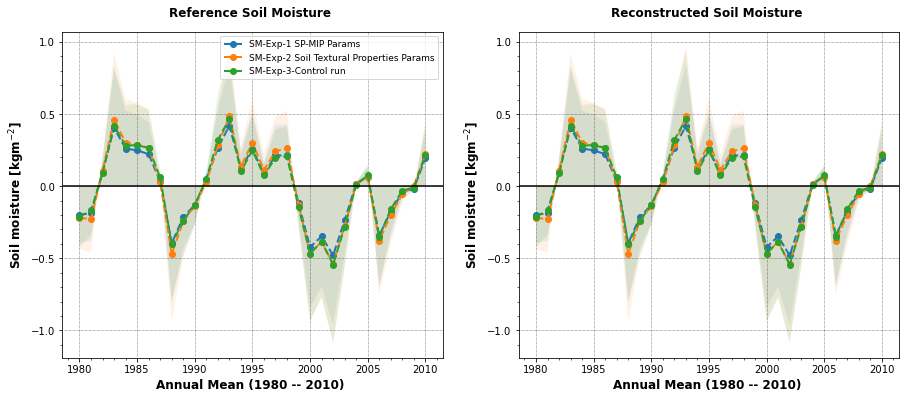

In [27]:
plt.figure(figsize = (15,6))
year = np.arange(1980,2011,1)
#============================================Reference Dataset 
plt.subplot(1,2,1)
plt.plot(year, np.delete(exp1_mrlsl_detrendT ,-1), \
         label="SM-Exp-1 SP-MIP Params",linewidth=2,linestyle='dashed',   marker="o")
plt.plot(year, np.delete(exp2_mrlsl_detrendT ,-1), \
         linewidth=2,label="SM-Exp-2 Soil Textural Properties Params",linestyle='dashed',   marker="o")
plt.plot(year, np.delete(exp3_mrlsl_detrendT ,-1), \
         linewidth=2,label="SM-Exp-3-Control run",linestyle='dashed',  marker="o")

plt.fill_between(year, np.delete(exp1_mrlsl_detrendT,-1)-np.delete(exp1_mrlsl_detrendT,-1), \
                 np.delete(exp1_mrlsl_detrendT,-1)+np.delete(exp1_mrlsl_detrendT,-1) ,alpha=0.1)
plt.fill_between(year, np.delete(exp2_mrlsl_detrendT,-1)-np.delete(exp2_mrlsl_detrendT,-1), \
                 np.delete(exp2_mrlsl_detrendT,-1)+np.delete(exp2_mrlsl_detrendT,-1) ,alpha=0.1)
plt.fill_between(year, np.delete(exp3_mrlsl_detrendT,-1)-np.delete(exp3_mrlsl_detrendT,-1), \
                 np.delete(exp3_mrlsl_detrendT,-1)+np.delete(exp3_mrlsl_detrendT,-1) ,alpha=0.1)
plt.xlabel("Annual Mean (1980 -- 2010) ",fontweight='bold',fontsize=12)
plt.ylabel("Soil moisture [kgm$^{-2}$]",fontweight='bold',  fontsize=12)
plt.title(f"Reference Soil Moisture ", pad=15,fontweight='bold', fontsize=12)#
plt.legend(loc="upper right", fontsize=9)
#plt.axhline(0, color='k')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.axhline(0, color='k')
plt.minorticks_on()
# plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
#           fancybox=True, shadow=True, ncol=5)
plt.grid(linestyle=':', linewidth=0.5, color='k')


#============================================Reconstructed Dataset 
plt.subplot(1,2,2)
plt.plot(year, np.delete(Exp1mrlsl_SMreconstructedT,-1), \
         label="SM-Exp-1 SP-MIP Params",linewidth=2,linestyle='dashed',   marker="o")
plt.plot(year, np.delete(Exp2mrlsl_SMreconstructedT,-1), \
         linewidth=2,label="SM-Exp-2 Soil Textural Properties Params",linestyle='dashed',   marker="o")
plt.plot(year, np.delete(Exp3mrlsl_SMreconstructedT,-1), \
         linewidth=2,label="SM-Exp-3-Control run",linestyle='dashed',  marker="o")

plt.fill_between(year, np.delete(Exp1mrlsl_SMreconstructedT,-1)-np.delete(Exp1mrlsl_SMreconstructedT,-1), \
                 np.delete(Exp1mrlsl_SMreconstructedT,-1)+np.delete(Exp1mrlsl_SMreconstructedT,-1) ,alpha=0.1)
plt.fill_between(year, np.delete(Exp2mrlsl_SMreconstructedT,-1)-np.delete(Exp2mrlsl_SMreconstructedT,-1), \
                 np.delete(Exp2mrlsl_SMreconstructedT,-1)+np.delete(Exp2mrlsl_SMreconstructedT,-1) ,alpha=0.1)
plt.fill_between(year, np.delete(Exp3mrlsl_SMreconstructedT,-1)-np.delete(Exp3mrlsl_SMreconstructedT,-1), \
                 np.delete(Exp3mrlsl_SMreconstructedT,-1)+np.delete(Exp3mrlsl_SMreconstructedT,-1) ,alpha=0.1)

plt.xlabel("Annual Mean (1980 -- 2010) ",fontweight='bold',fontsize=12)
plt.ylabel("Soil moisture [kgm$^{-2}$]",fontweight='bold',  fontsize=12)
plt.title(f"Reconstructed Soil Moisture ", pad=15,fontweight='bold', fontsize=12)#[kgm$^{-2}$]
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.axhline(0, color='k')
plt.minorticks_on()
#plt.legend(loc='upper center', bbox_to_anchor=(-0.1, -0.15),
#          fancybox=True, shadow=True, ncol=5)

plt.grid(linestyle=':', linewidth=0.5, color='k')
plt.show()


####  Stacked Bar Plot

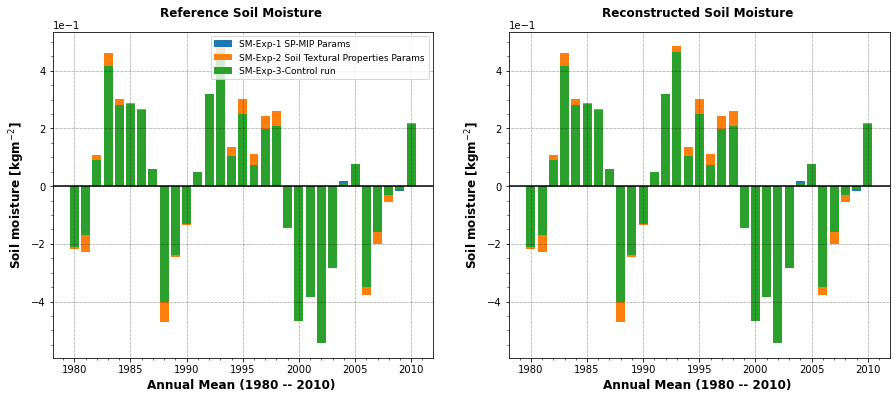

In [28]:
plt.figure(figsize = (15,6))
year = np.arange(1980,2011,1)
#============================================Reference Dataset
plt.subplot(1,2,1)
plt.bar(year, np.delete(exp1_mrlsl_detrendT ,-1),label="SM-Exp-1 SP-MIP Params")
plt.bar(year, np.delete(exp2_mrlsl_detrendT ,-1),label="SM-Exp-2 Soil Textural Properties Params")
plt.bar(year, np.delete(exp3_mrlsl_detrendT ,-1),label="SM-Exp-3-Control run")
plt.xlabel("Annual Mean (1980 -- 2010) ",fontweight='bold',fontsize=12)
plt.ylabel("Soil moisture [kgm$^{-2}$]",fontweight='bold',  fontsize=12)
plt.title(f"Reference Soil Moisture ", pad=15,fontweight='bold', fontsize=12)#
plt.legend(loc="upper right", fontsize=9)
#plt.axhline(0, color='k')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.axhline(0, color='k')
plt.minorticks_on()
plt.grid(linestyle=':', linewidth=0.5, color='k')

#============================================Reconstructed Dataset 
plt.subplot(1,2,2)
plt.bar(year, np.delete(Exp1mrlsl_SMreconstructedT,-1),label="SM-Exp-1 SP-MIP Params")
plt.bar(year, np.delete(Exp2mrlsl_SMreconstructedT,-1),label="SM-Exp-2 Soil Textural Properties Params")
plt.bar(year, np.delete(Exp3mrlsl_SMreconstructedT,-1), label="SM-Exp-3-Control run")
plt.xlabel("Annual Mean (1980 -- 2010) ",fontweight='bold',fontsize=12)
plt.ylabel("Soil moisture [kgm$^{-2}$]",fontweight='bold',  fontsize=12)
plt.title(f"Reconstructed Soil Moisture ", pad=15,fontweight='bold', fontsize=12)#[kgm$^{-2}$]
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.axhline(0, color='k')
plt.minorticks_on()
plt.grid(linestyle=':', linewidth=0.5, color='k')
plt.show()

 #### Reference and Constructed Experiment 4a-d SPMIP Dataset Spatial Maps

In [29]:
# reconstructed11 = np.mean(reconstruction11,axis=0)
# reconstructed22 = np.mean(reconstruction22,axis=0)
# reconstructed33 = np.mean(reconstruction33,axis=0)
# reconstructed44 = np.mean(reconstruction44,axis=0)

#============================================Detrending Reference Data
exp4a_mrlsl_detrend = signal.detrend(exp4a_mrlsl,axis=0, type='constant',bp=0)
exp4b_mrlsl_detrend = signal.detrend(exp4b_mrlsl,axis=0, type='constant',bp=0)
exp4c_mrlsl_detrend = signal.detrend(exp4c_mrlsl,axis=0, type='constant',bp=0)
exp4d_mrlsl_detrend = signal.detrend(exp4d_mrlsl,axis=0, type='constant',bp=0)


#============================================Reference xarray Dataset 
Exp4amrlsl_SMreconstructedxr = xr.DataArray(reconstruction4a,
                           coords=soilmoisture.coords, dims=soilmoisture.dims, attrs=data_EX1.attrs)
Exp4bmrlsl_SMreconstructedxr = xr.DataArray(reconstruction4b,
                           coords=soilmoisture.coords, dims=soilmoisture.dims, attrs=data_EX1.attrs)
Exp4cmrlsl_SMreconstructedxr = xr.DataArray(reconstruction4c,
                           coords=soilmoisture.coords, dims=soilmoisture.dims, attrs=data_EX1.attrs)
Exp4dmrlsl_SMreconstructedxr = xr.DataArray(reconstruction4d,
                           coords=soilmoisture.coords, dims=soilmoisture.dims, attrs=data_EX1.attrs)

#============================================Reconstructed xarray Dataset 
exp4a_mrlsl_detrendxr = xr.DataArray(exp4a_mrlsl_detrend,
                           coords=soilmoisture.coords, dims=soilmoisture.dims, attrs=data_EX1.attrs)
exp4b_mrlsl_detrendxr = xr.DataArray(exp4b_mrlsl_detrend,
                           coords=soilmoisture.coords, dims=soilmoisture.dims, attrs=data_EX1.attrs)
exp4c_mrlsl_detrendxr = xr.DataArray(exp4c_mrlsl_detrend,
                           coords=soilmoisture.coords, dims=soilmoisture.dims, attrs=data_EX1.attrs)
exp4d_mrlsl_detrendxr = xr.DataArray(exp4d_mrlsl_detrend,
                           coords=soilmoisture.coords, dims=soilmoisture.dims, attrs=data_EX1.attrs)

## Visualizing the constructed and reference Data 

The constructed data is the subset of the modes with higher explaining variance and reference data is the original dataset that is decomposed into EOF modes.

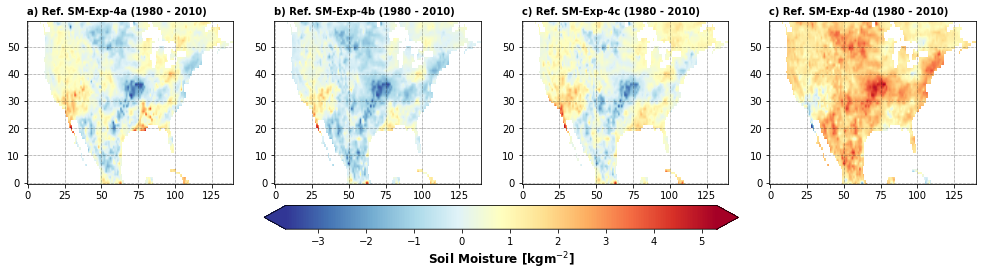

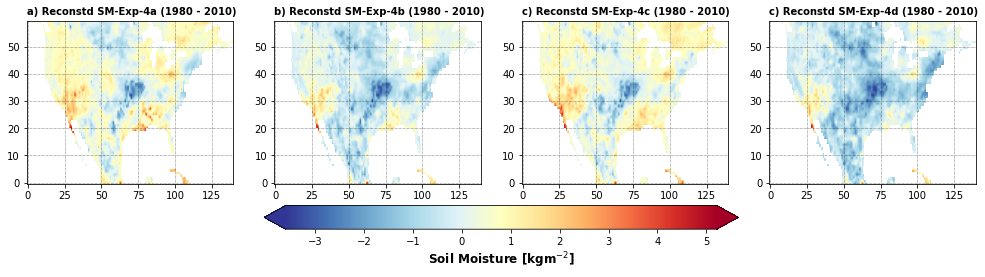

In [30]:
#============================================Reference Dataset 
fig, axs = plt.subplots(nrows=1,ncols=4, sharex=True, \
                        figsize=[17,4], gridspec_kw={'wspace':.20, 'hspace':.22})
kwargs = {'format': '%.0f'} 
 
axs[0].set_title('a) Ref. SM-Exp-4a (1980 - 2010)',\
                 fontweight='bold', fontsize=10, loc='left')
original1=axs[0].imshow(exp4a_mrlsl_detrend[0,:,:].squeeze() ,\
                        cmap='RdYlBu_r', interpolation='bilinear', aspect='auto', origin='lower')
#axs[0].set_title("EOF 1", loc='right',fontweight='bold',size=10)
axs[0].grid(linestyle=':', linewidth=0.5, color='k')

axs[1].set_title('b) Ref. SM-Exp-4b (1980 - 2010)', \
                 fontweight='bold',fontsize=10, loc='left')
original2=axs[1].imshow(exp4b_mrlsl_detrend[0,:,:].squeeze(), \
                        cmap='RdYlBu_r', interpolation='bilinear', aspect='auto', origin='lower')
#axs[1].set_title("EOF 1", loc='right',fontweight='bold',size=10)
axs[1].grid(linestyle=':', linewidth=0.5, color='k')   

axs[2].set_title('c) Ref. SM-Exp-4c (1980 - 2010)',fontweight='bold', fontsize=10, loc='left')
original3=axs[2].imshow(exp4c_mrlsl_detrend[0,:,:].squeeze(), \
                        cmap='RdYlBu_r', interpolation='bilinear', aspect='auto', origin='lower')
#axs[2].set_title("EOF 1", loc='right',fontweight='bold',size=10)
axs[2].grid(linestyle=':', linewidth=0.5, color='k')

axs[3].set_title('c) Ref. SM-Exp-4d (1980 - 2010)',fontweight='bold', fontsize=10, loc='left')
original3=axs[3].imshow(exp4d_mrlsl_detrend[0,:,:].squeeze(), \
                        cmap='RdYlBu', interpolation='bilinear', aspect='auto', origin='lower')
#axs[3].set_title("EOF 1", loc='right',fontweight='bold',size=10)
axs[3].grid(linestyle=':', linewidth=0.5, color='k')

cb =plt.colorbar(original2, cmap='RdYlBu_r', ax=axs.ravel().tolist(), \
                 orientation='horizontal', shrink=0.5,extend='both', pad=0.099)
cb.set_label('Soil Moisture [kgm$^{-2}$]',fontweight='bold', fontsize=12)#.set_label(label='new label',size=15,weight='bold')

#============================================Reconstructed Dataset 
fig, axs = plt.subplots(nrows=1,ncols=4, sharex=True, figsize=[17,4],\
                        gridspec_kw={'wspace':.20, 'hspace':.22})
kwargs = {'format': '%.0f'} 
 
axs[0].set_title('a) Reconstd SM-Exp-4a (1980 - 2010)',fontweight='bold', fontsize=10, loc='left')
original1=axs[0].imshow(Exp4amrlsl_SMreconstructedxr[0,:,:].squeeze() , \
                        cmap='RdYlBu_r', interpolation='bilinear', aspect='auto', origin='lower')
#axs[0].set_title("EOF 1", loc='right',fontweight='bold',size=10)
axs[0].grid(linestyle=':', linewidth=0.5, color='k')

axs[1].set_title('b) Reconstd SM-Exp-4b (1980 - 2010)', fontweight='bold',fontsize=10, loc='left')
original2=axs[1].imshow(Exp4bmrlsl_SMreconstructedxr[0,:,:].squeeze(), \
                        cmap='RdYlBu_r', interpolation='bilinear', aspect='auto', origin='lower')
#axs[1].set_title("EOF 1", loc='right',fontweight='bold',size=10)
axs[1].grid(linestyle=':', linewidth=0.5, color='k')   

axs[2].set_title('c) Reconstd SM-Exp-4c (1980 - 2010)',fontweight='bold', fontsize=10, loc='left')
original3=axs[2].imshow(Exp4cmrlsl_SMreconstructedxr[0,:,:].squeeze(), \
                        cmap='RdYlBu_r', interpolation='bilinear', aspect='auto', origin='lower')
#axs[2].set_title("EOF 1", loc='right',fontweight='bold',size=10)
axs[2].grid(linestyle=':', linewidth=0.5, color='k')

axs[3].set_title('c) Reconstd SM-Exp-4d (1980 - 2010)',fontweight='bold', fontsize=10, loc='left')
original3=axs[3].imshow(Exp4dmrlsl_SMreconstructedxr[0,:,:].squeeze(), \
                        cmap='RdYlBu_r', interpolation='bilinear', aspect='auto', origin='lower')
#axs[3].set_title("EOF 1", loc='right',fontweight='bold',size=10)
axs[3].grid(linestyle=':', linewidth=0.5, color='k')

cb =plt.colorbar(original2, cmap='RdYlBu_r', ax=axs.ravel().tolist(), \
                 orientation='horizontal', shrink=0.5,extend='both', pad=0.099)
cb.set_label('Soil Moisture [kgm$^{-2}$]',fontweight='bold', fontsize=12)#.set_label(label='new label',size=15,weight='bold')

### Time Series of Reference and Constructed Dataset Experiment 4a-d

<div class="alert alert-success">
<strong> Time Series of Reference and Constructed Dataset Experiment 4a-d </strong> 


In [31]:
#============================================Reference Exp 1-3
exp4a_mrlsl_detrendT = exp4a_mrlsl_detrendxr.mean(dim=("lat","lon"))
exp4b_mrlsl_detrendT = exp4b_mrlsl_detrendxr.mean(dim=("lat","lon"))
exp4c_mrlsl_detrendT = exp4c_mrlsl_detrendxr.mean(dim=("lat","lon"))
exp4d_mrlsl_detrendT = exp4d_mrlsl_detrendxr.mean(dim=("lat","lon"))

#============================================Reconstructed Exp 1-3
Exp4amrlsl_SMreconstructedT = Exp4amrlsl_SMreconstructedxr.mean(dim=("lat","lon"))
Exp4bmrlsl_SMreconstructedT = Exp4bmrlsl_SMreconstructedxr.mean(dim=("lat","lon"))
Exp4cmrlsl_SMreconstructedT = Exp4cmrlsl_SMreconstructedxr.mean(dim=("lat","lon"))
Exp4dmrlsl_SMreconstructedT = Exp4dmrlsl_SMreconstructedxr.mean(dim=("lat","lon"))

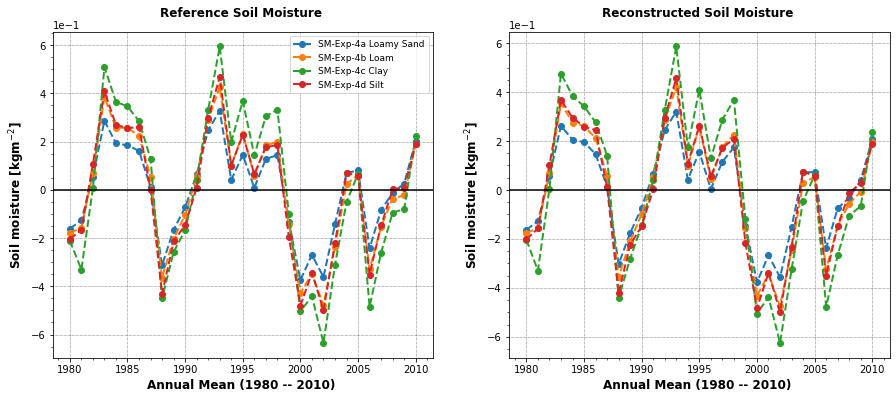

In [32]:
plt.figure(figsize = (15,6))
year = np.arange(1980,2011,1)
#============================================Reference Dataset 
plt.subplot(1,2,1)
plt.plot(year, np.delete(exp4a_mrlsl_detrendT,-1), \
         label="SM-Exp-4a Loamy Sand",linewidth=2,linestyle='dashed',   marker="o")
plt.plot(year, np.delete(exp4b_mrlsl_detrendT,-1), \
         linewidth=2,label="SM-Exp-4b Loam",linestyle='dashed',   marker="o")
plt.plot(year, np.delete(exp4c_mrlsl_detrendT,-1), \
         linewidth=2,label="SM-Exp-4c Clay",linestyle='dashed',  marker="o")
plt.plot(year, np.delete(exp4d_mrlsl_detrendT,-1), \
         linewidth=2,label="SM-Exp-4d Silt",linestyle='dashed',  marker="o")
plt.xlabel("Annual Mean (1980 -- 2010) ",fontweight='bold',fontsize=12)
plt.ylabel("Soil moisture [kgm$^{-2}$]",fontweight='bold',  fontsize=12)
plt.title(f"Reference Soil Moisture ", pad=15,fontweight='bold', fontsize=12)#[kgm$^{-2}$]
plt.legend(loc="upper right", fontsize=9)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.axhline(0, color='k')
plt.minorticks_on()
plt.grid(linestyle=':', linewidth=0.5, color='k')

#============================================Reconstructed Dataset 
plt.subplot(1,2,2)
plt.plot(year, np.delete(Exp4amrlsl_SMreconstructedT ,-1), \
         label="SM-Exp-4a Loamy Sand",linewidth=2,linestyle='dashed',   marker="o")
plt.plot(year, np.delete(Exp4bmrlsl_SMreconstructedT ,-1), \
         linewidth=2,label="SM-Exp-4b Loam",linestyle='dashed',   marker="o")
plt.plot(year, np.delete(Exp4cmrlsl_SMreconstructedT ,-1), \
         linewidth=2,label="SM-Exp-4c Clay",linestyle='dashed',  marker="o")
plt.plot(year, np.delete(Exp4dmrlsl_SMreconstructedT ,-1), \
         linewidth=2,label="SM-Exp-4d Silt",linestyle='dashed',  marker="o")
plt.xlabel("Annual Mean (1980 -- 2010) ",fontweight='bold',fontsize=12)
plt.ylabel("Soil moisture [kgm$^{-2}$]",fontweight='bold',  fontsize=12)
plt.title(f"Reconstructed Soil Moisture ", pad=15,fontweight='bold', fontsize=12)#[kgm$^{-2}$]
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.axhline(0, color='k')
plt.minorticks_on()
plt.grid(linestyle=':', linewidth=0.5, color='k')
plt.show()

####  Stacked Bar Plot

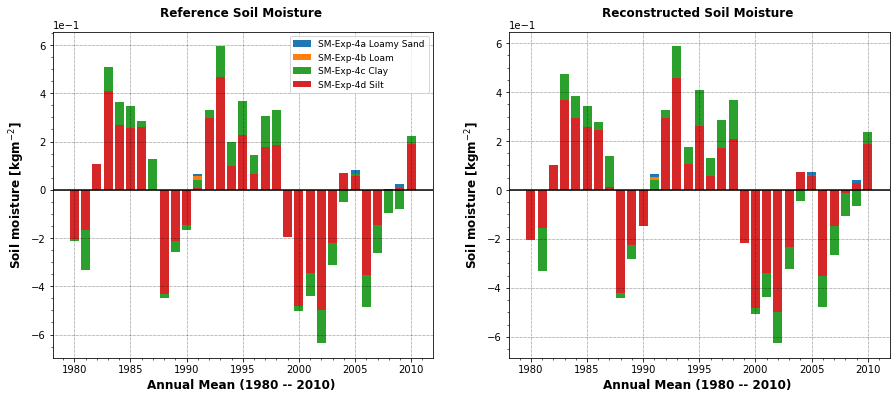

In [33]:
plt.figure(figsize = (15,6))
year = np.arange(1980,2011,1)
#============================================Reference Dataset 
plt.subplot(1,2,1)
plt.bar(year, np.delete(exp4a_mrlsl_detrendT,-1),label="SM-Exp-4a Loamy Sand")
plt.bar(year, np.delete(exp4b_mrlsl_detrendT,-1),label="SM-Exp-4b Loam")
plt.bar(year, np.delete(exp4c_mrlsl_detrendT,-1), label="SM-Exp-4c Clay")
plt.bar(year, np.delete(exp4d_mrlsl_detrendT,-1), label="SM-Exp-4d Silt")
plt.xlabel("Annual Mean (1980 -- 2010) ",fontweight='bold',fontsize=12)
plt.ylabel("Soil moisture [kgm$^{-2}$]",fontweight='bold',  fontsize=12)
plt.title(f"Reference Soil Moisture ", pad=15,fontweight='bold', fontsize=12)#[kgm$^{-2}$]
plt.legend(loc="upper right", fontsize=9)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.axhline(0, color='k')
plt.minorticks_on()
plt.grid(linestyle=':', linewidth=0.5, color='k')

#============================================Reconstructed Dataset 
plt.subplot(1,2,2)
plt.bar(year, np.delete(Exp4amrlsl_SMreconstructedT ,-1), label="SM-Exp-4a Loamy Sand")
plt.bar(year, np.delete(Exp4bmrlsl_SMreconstructedT ,-1),label="SM-Exp-4b Loam")
plt.bar(year, np.delete(Exp4cmrlsl_SMreconstructedT ,-1), label="SM-Exp-4c Clay")
plt.bar(year, np.delete(Exp4dmrlsl_SMreconstructedT ,-1), label="SM-Exp-4d Silt")
plt.xlabel("Annual Mean (1980 -- 2010) ",fontweight='bold',fontsize=12)
plt.ylabel("Soil moisture [kgm$^{-2}$]",fontweight='bold',  fontsize=12)
plt.title(f"Reconstructed Soil Moisture ", pad=15,fontweight='bold', fontsize=12)#[kgm$^{-2}$]
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.axhline(0, color='k')
plt.minorticks_on()
plt.grid(linestyle=':', linewidth=0.5, color='k')
plt.show()

### Exploring the variability by adding the daily standard deviation as a shaded area to the plot

The standard deviation allows us to see when EOF underpredicts or overpredicts the soil moisture.

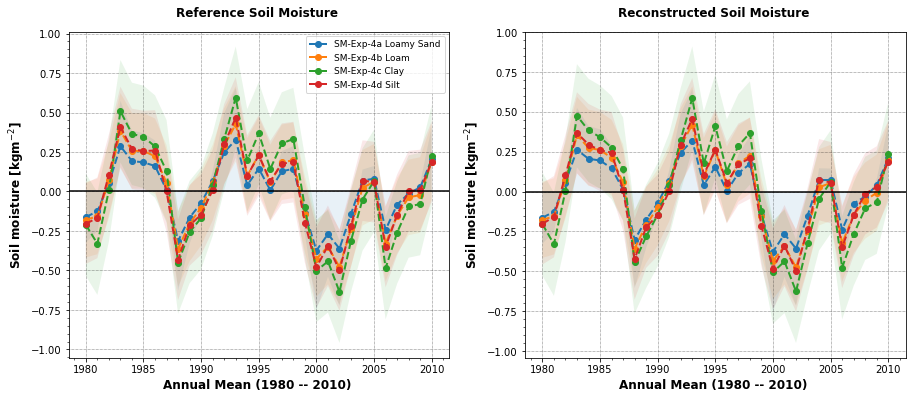

In [34]:
plt.figure(figsize = (15,6))
year = np.arange(1980,2011,1)
#============================================Reference Dataset 
plt.subplot(1,2,1)
plt.plot(year, np.delete(exp4a_mrlsl_detrendT,-1), \
         label="SM-Exp-4a Loamy Sand",linewidth=2,linestyle='dashed',   marker="o")
plt.plot(year, np.delete(exp4b_mrlsl_detrendT,-1), \
         linewidth=2,label="SM-Exp-4b Loam",linestyle='dashed',   marker="o")
plt.plot(year, np.delete(exp4c_mrlsl_detrendT,-1), \
         linewidth=2,label="SM-Exp-4c Clay",linestyle='dashed',  marker="o")
plt.plot(year, np.delete(exp4d_mrlsl_detrendT,-1), \
         linewidth=2,label="SM-Exp-4d Silt",linestyle='dashed',  marker="o")
plt.fill_between(year, np.delete(exp4a_mrlsl_detrendT,-1)-np.delete(exp4a_mrlsl_detrendT,-1), \
                 np.delete(exp4a_mrlsl_detrendT,-1)+np.delete(exp4a_mrlsl_detrendT,-1) ,alpha=0.1)
plt.fill_between(year, np.delete(exp4b_mrlsl_detrendT,-1)-np.delete(exp4b_mrlsl_detrendT,-1).std(),\
                 np.delete(exp4b_mrlsl_detrendT,-1)+np.delete(exp4b_mrlsl_detrendT,-1).std() ,alpha=0.1)
plt.fill_between(year, np.delete(exp4c_mrlsl_detrendT,-1)-np.delete(exp4c_mrlsl_detrendT,-1).std(), \
                 np.delete(exp4c_mrlsl_detrendT,-1)+np.delete(exp4c_mrlsl_detrendT,-1).std() ,alpha=0.1)
plt.fill_between(year, np.delete(exp4d_mrlsl_detrendT,-1)-np.delete(exp4d_mrlsl_detrendT,-1).std(), \
                 np.delete(exp4d_mrlsl_detrendT,-1)+np.delete(exp4d_mrlsl_detrendT,-1).std() ,alpha=0.1)
plt.xlabel("Annual Mean (1980 -- 2010) ",fontweight='bold',fontsize=12)
plt.ylabel("Soil moisture [kgm$^{-2}$]",fontweight='bold',  fontsize=12)
plt.title(f"Reference Soil Moisture ", pad=15,fontweight='bold', fontsize=12)#[kgm$^{-2}$]
plt.legend(loc="upper right", fontsize=9)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.axhline(0, color='k')
plt.minorticks_on()
plt.grid(linestyle=':', linewidth=0.5, color='k')


#============================================Reconstructed Dataset 
plt.subplot(1,2,2)
plt.plot(year, np.delete(Exp4amrlsl_SMreconstructedT ,-1), \
         label="SM-Exp-4a Loamy Sand",linewidth=2,linestyle='dashed',   marker="o")
plt.plot(year, np.delete(Exp4bmrlsl_SMreconstructedT ,-1), \
         linewidth=2,label="SM-Exp-4b Loam",linestyle='dashed',   marker="o")
plt.plot(year, np.delete(Exp4cmrlsl_SMreconstructedT ,-1), \
         linewidth=2,label="SM-Exp-4c Clay",linestyle='dashed',  marker="o")
plt.plot(year, np.delete(Exp4dmrlsl_SMreconstructedT ,-1), \
         linewidth=2,label="SM-Exp-4d Silt",linestyle='dashed',  marker="o")
plt.fill_between(year, np.delete(Exp4amrlsl_SMreconstructedT,-1)-np.delete(Exp4amrlsl_SMreconstructedT,-1), \
                 np.delete(Exp4amrlsl_SMreconstructedT,-1)+np.delete(Exp4amrlsl_SMreconstructedT,-1) ,alpha=0.1)
plt.fill_between(year, np.delete(Exp4bmrlsl_SMreconstructedT,-1)-np.delete(Exp4bmrlsl_SMreconstructedT,-1).std(),\
                 np.delete(Exp4bmrlsl_SMreconstructedT,-1)+np.delete(Exp4bmrlsl_SMreconstructedT,-1).std() ,alpha=0.1)
plt.fill_between(year, np.delete(Exp4cmrlsl_SMreconstructedT,-1)-np.delete(Exp4cmrlsl_SMreconstructedT,-1).std(), \
                 np.delete(Exp4cmrlsl_SMreconstructedT,-1)+np.delete(Exp4cmrlsl_SMreconstructedT,-1).std() ,alpha=0.1)
plt.fill_between(year, np.delete(Exp4dmrlsl_SMreconstructedT,-1)-np.delete(Exp4dmrlsl_SMreconstructedT,-1).std(), \
                 np.delete(Exp4dmrlsl_SMreconstructedT,-1)+np.delete(Exp4dmrlsl_SMreconstructedT,-1).std() ,alpha=0.1)
plt.xlabel("Annual Mean (1980 -- 2010) ",fontweight='bold',fontsize=12)
plt.ylabel("Soil moisture [kgm$^{-2}$]",fontweight='bold',  fontsize=12)
plt.title(f"Reconstructed Soil Moisture ", pad=15,fontweight='bold', fontsize=12)#[kgm$^{-2}$]
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.axhline(0, color='k')
plt.minorticks_on()
plt.grid(linestyle=':', linewidth=0.5, color='k')
plt.show()